In [28]:
import numpy as np
import pandas as pd
from torch import nn
import torch
import torch.utils.data as data
import matplotlib.pyplot as plt
import warnings

plt.rcParams['font.sans-serif'] = ['SimHei']#用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False#用来正常显示负号
plt.rcParams['figure.dpi']=100#分辨率

device="cuda" if torch.cuda.is_available() else "cpu"
warnings.filterwarnings('ignore')

In [29]:
class MyDataset(data.Dataset):
    def __init__(self,data_list):
        self.data_list=data_list
    def __len__(self):
        return len(self.data_list)
    def __getitem__(self,index):
        x=self.data_list[index][0]
        y=self.data_list[index][1]
        return x,y
    

In [30]:
#训练函数
def train(dataloader,model,loss_fn,optimizer):
    size=len(dataloader.dataset)#训练集大小
    num_batches=len(dataloader)#批次数目，（size/batch_size，向上取整）

    train_loss,train_acc=0,0#初始化训练损失和正确率

    for imgs,target in dataloader:#获取图片及标签
        imgs,target=imgs.to(device),target.to(device)

        imgs=imgs.to(device,dtype=torch.float)
        
        #计算预测误差
        pred=model(imgs)#网络输出
        target=target.long()
        # print('pred:',pred)
        # print('target:',target)
        loss=loss_fn(pred,target)#计算网络输出和真实值之间的差距

        #反向传播
        optimizer.zero_grad()#grad属性归零
        loss.backward()#反向传播
        optimizer.step()#每一步自动更新

        #记录acc和loss
        train_acc+=(pred.argmax(1)==target).type(torch.float).sum().item()
        train_loss+=loss.item()

    train_acc/=size
    train_loss/=num_batches

    return train_acc,train_loss

#测试函数
def val(dataloader,model,loss_fn):
    size=len(dataloader.dataset)#测试集的大小
    num_batches=len(dataloader)#批次数目，（size/batch_size,向上取整）
    val_loss,val_acc=0,0

    #当不进行训练时。停止梯度更新，节省计算内存消耗
    with torch.no_grad():
        for imgs,target in dataloader:
            imgs,target=imgs.to(device),target.to(device)

            imgs=imgs.to(device,dtype=torch.float)
            
            
            #计算loss
            target_pred=model(imgs)
            target=target.long()
            loss=loss_fn(target_pred,target)

            val_loss+=loss.item()
            val_acc+=(target_pred.argmax(1)==target).type(torch.float).sum().item()

    val_acc/=size
    val_loss/=num_batches
    return val_acc,val_loss

In [31]:
data_=pd.read_excel(r"D:\20250106project\2.comebine\CNN.xlsx",index_col=0)
X=data_.iloc[:,:-1].values
y=data_.iloc[:,-1].values


In [32]:
columns = data_.iloc[:,:-1].columns.values

In [33]:
from sklearn.model_selection import train_test_split
# 首先划分出训练集和剩余部分（暂称为临时集，后续再从临时集中划分验证集和测试集）
X_train, X_temp, y_train, y_temp = train_test_split(X, y,train_size=0.7, random_state=42 ,stratify=y)

# 再从临时集中划分验证集和测试集，这里验证集占临时集的1/3（因为要达到整体的1:2比例），测试集占2/3
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=28,stratify=y_temp)

print("训练集特征形状:", X_train.shape)
print("训练集标签形状:", y_train.shape)
print("验证集特征形状:", X_val.shape)
print("验证集标签形状:", y_val.shape)
print("测试集特征形状:", X_test.shape)
print("测试集标签形状:", y_test.shape)


# #print("y_temp",y_temp)
# print("test")
# unique_values, counts = np.unique(y_val, return_counts=True)
# # 打印不同类别的数量
# num_categories = len(unique_values)
# print("不同类别的数量：", num_categories)
# print("不同类别的数量：", unique_values)
# print("counts=",counts)
# y_test


训练集特征形状: (425, 16001)
训练集标签形状: (425,)
验证集特征形状: (61, 16001)
验证集标签形状: (61,)
测试集特征形状: (122, 16001)
测试集标签形状: (122,)


In [34]:
X_train=X_train.reshape((-1,1,16001))
X_test=X_test.reshape((-1,1,16001))
X_val=X_val.reshape((-1,1,16001))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(425, 1, 16001)
(122, 1, 16001)
(425,)
(122,)


In [35]:
train_data=[]
test_data=[]
val_data=[]

train_data=[[i,j] for i,j in zip(X_train,y_train)]
test_data=[[i,j] for i,j in zip(X_test,y_test)]
val_data=[[i,j] for i,j in zip(X_val,y_val)]

In [36]:
batch=64

train_dataset=MyDataset(train_data)
train_dataloader=data.DataLoader(train_dataset,batch_size=batch,shuffle=True)

test_dataset=MyDataset(test_data)
test_dataloader=data.DataLoader(test_dataset,batch_size=batch,shuffle=False)

val_dataset=MyDataset(val_data)
val_dataloader=data.DataLoader(val_dataset,batch_size=batch,shuffle=False)
# 检查数据集的大小  
print('Train set: {} samples'.format(len(train_dataloader)))  
print('Test set: {} samples'.format(len(test_dataloader)))  
print('val set: {} samples'.format(len(val_dataloader)))  

# 获取一批训练数据  
images, labels = next(iter(train_dataloader))  
print('Image batch shape:', images.size())  

Train set: 7 samples
Test set: 2 samples
val set: 1 samples
Image batch shape: torch.Size([64, 1, 16001])


In [37]:
class OneDCNN(nn.Module):
    def __init__(self):
        super(OneDCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3)  # 1. 定义卷积层 Conv1
        self.bn1 = nn.BatchNorm1d(32)  # 2. 定义批量归一化层 BN1
        self.relu1 = nn.ReLU()  # 3. 定义激活函数层 ReLU1

        self.maxpool1 = nn.MaxPool1d(2)  # 4. 定义池化层 Maxpooling1

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)  # 5. 定义卷积层 Conv2
        self.bn2 = nn.BatchNorm1d(64)  # 6. 定义批量归一化层 BN2
        self.relu2 = nn.ReLU()  # 7. 定义激活函数层 ReLU2

        self.maxpool2 = nn.MaxPool1d(2)  # 8. 定义池化层 Maxpooling2

        # 我们不指定 fc4 的输入大小，而是动态计算
        self.fc4 = None  # 初始化 fc4 为 None

        self.dropout = nn.Dropout(0.2)  # 14. 定义 Dropout 层

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # 打印每一层的输出形状来调试
        print(f"After conv1 and maxpool1: {x.shape}")
        print(f"After conv2 and maxpool2: {x.shape}")

        # 动态计算展平后的大小
        flat_size = x.view(x.size(0), -1).size(1)

        # 只有在第一次传入数据时才定义全连接层的大小
        if self.fc4 is None:
            self.fc4 = nn.Linear(flat_size, 50)  # 14 是最终的类别数，替换为你的类别数

        x = x.view(x.size(0), -1)
        print(f"After flatten: {x.shape}")

        x = self.fc4(x)
        x = self.dropout(x)

        return x

In [38]:
model = OneDCNN()

In [39]:
#查看模型详情
import torchsummary as summary
summary.summary(model,(1,16001))

After conv1 and maxpool1: torch.Size([2, 64, 3998])
After conv2 and maxpool2: torch.Size([2, 64, 3998])
After flatten: torch.Size([2, 255872])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 32, 15999]             128
       BatchNorm1d-2            [-1, 32, 15999]              64
              ReLU-3            [-1, 32, 15999]               0
         MaxPool1d-4             [-1, 32, 7999]               0
            Conv1d-5             [-1, 64, 7997]           6,208
       BatchNorm1d-6             [-1, 64, 7997]             128
              ReLU-7             [-1, 64, 7997]               0
         MaxPool1d-8             [-1, 64, 3998]               0
           Dropout-9                   [-1, 50]               0
Total params: 6,528
Trainable params: 6,528
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.

In [40]:
#正式训练
import copy
import time

optimizer=torch.optim.Adam(model.parameters(),1e-4)
# optimizer=torch.optim.SGD(model1.parameters(),lr=1e-4,momentum=1)
loss_fn=nn.CrossEntropyLoss()#创建损失函数

epochs=100

train_loss=[]
train_acc=[]
val_loss=[]
val_acc=[]

best_acc=0#设置一个最佳准确率，作为最佳模型的判别指标

#记录开始时间
start_time=time.time()

for epoch in range(epochs):
    model.train()
    _,_=train(train_dataloader,model,loss_fn,optimizer)

    model.eval()
    epoch_train_acc,epoch_train_loss=val(train_dataloader,model,loss_fn)
    epoch_val_acc,epoch_val_loss=val(val_dataloader,model,loss_fn)

    #保存最佳模型到best_model
    if epoch_val_acc>best_acc:
        best_acc=epoch_val_acc
        best_model=copy.deepcopy(model)
        print('最佳模型epoch为:',epoch)

    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    val_acc.append(epoch_val_acc)
    val_loss.append(epoch_val_loss)

    #获取当前学习率
    lr=optimizer.state_dict()['param_groups'][0]['lr']
    template=('Epoch:{:2d},Train_acc:{:.1f}%,Train_loss:{:.3f},Val_acc:{:.1f}%,Val_loss:{:.3f},Lr:{:.4f}')
    print(template.format(epoch+1,epoch_train_acc*100,epoch_train_loss,epoch_val_acc*100,epoch_val_loss,lr))


#记录结束时间
end_time=time.time()
#计算执行时间
execution_time=end_time-start_time
#输出执行时间
print("执行时间：",execution_time,"秒")

print('Done')

After conv1 and maxpool1: torch.Size([64, 64, 3998])
After conv2 and maxpool2: torch.Size([64, 64, 3998])
After flatten: torch.Size([64, 255872])
After conv1 and maxpool1: torch.Size([64, 64, 3998])
After conv2 and maxpool2: torch.Size([64, 64, 3998])
After flatten: torch.Size([64, 255872])
After conv1 and maxpool1: torch.Size([64, 64, 3998])
After conv2 and maxpool2: torch.Size([64, 64, 3998])
After flatten: torch.Size([64, 255872])
After conv1 and maxpool1: torch.Size([64, 64, 3998])
After conv2 and maxpool2: torch.Size([64, 64, 3998])
After flatten: torch.Size([64, 255872])
After conv1 and maxpool1: torch.Size([64, 64, 3998])
After conv2 and maxpool2: torch.Size([64, 64, 3998])
After flatten: torch.Size([64, 255872])
After conv1 and maxpool1: torch.Size([64, 64, 3998])
After conv2 and maxpool2: torch.Size([64, 64, 3998])
After flatten: torch.Size([64, 255872])
After conv1 and maxpool1: torch.Size([41, 64, 3998])
After conv2 and maxpool2: torch.Size([41, 64, 3998])
After flatten: tor

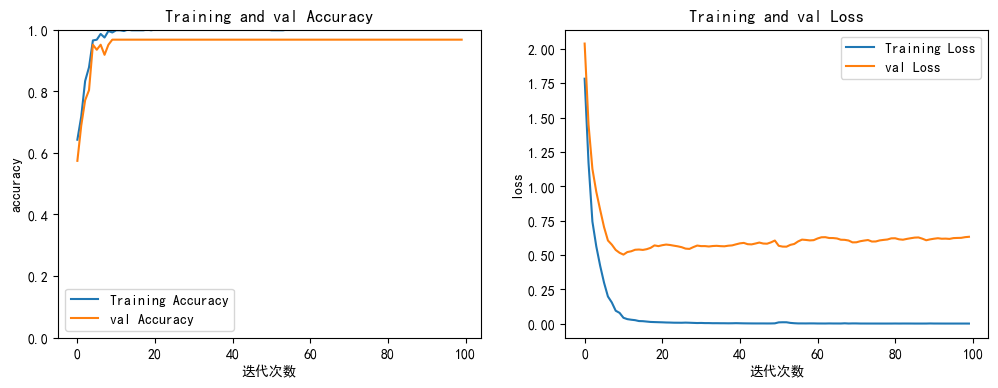

In [41]:
epochs_range=range(len(train_loss))
plt.rcParams['font.family'] = ['SimHei']
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)

plt.plot(epochs_range,train_acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='val Accuracy')
plt.legend(loc='best')
plt.xlabel('迭代次数')
plt.ylabel('accuracy')
plt.title('Training and val Accuracy')
# 设置 y 轴范围
plt.ylim(0, 1.0)

plt.subplot(1,2,2)
plt.plot(epochs_range,train_loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='val Loss')
plt.legend(loc='best')
plt.xlabel('迭代次数')
plt.ylabel('loss')
plt.title('Training and val Loss')
plt.savefig('accuracy_loss.png',dpi=800)

plt.show()

In [42]:
#保存最佳模型到文件中
PATH='./oneCNN_model.pth'
torch.save(best_model.state_dict(),PATH)

In [43]:
X_test_torch=torch.from_numpy(X_test)
X_test_torch=torch.reshape(X_test_torch,(-1,1,16001))
X_test_torch=X_test_torch.to(dtype=torch.float)
model.eval()
with torch.no_grad():
    outputs_LeNet = model(X_test_torch)
print(outputs_LeNet)

After conv1 and maxpool1: torch.Size([122, 64, 3998])
After conv2 and maxpool2: torch.Size([122, 64, 3998])
After flatten: torch.Size([122, 255872])
tensor([[ 14.2485, -33.5534, -38.1925,  ..., -30.3394, -21.1684, -30.9722],
        [-23.1768, -24.1604, -34.9827,  ...,  -9.0521, -27.9727, -20.0792],
        [-40.3948, -29.2659, -38.9077,  ..., -32.0851, -30.3396, -26.4124],
        ...,
        [ -8.6453,  -5.6572,  -9.2004,  ...,  -7.9966,  -6.3591,   7.7807],
        [-34.6022, -54.0001, -63.9015,  ..., -46.5403, -52.7813, -52.9683],
        [-47.7105, -42.6003, -61.2382,  ..., -52.1692, -31.1961, -17.5781]])


In [44]:
def SCIPlot():
    plt.grid(False)
    plt.box(True)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    plt.rcParams['font.family'] = ['Times New Roman', 'Arial', 'Helvetica']
    return ax

In [45]:
from sklearn.metrics import roc_curve,auc
y_pred_proba_smica=outputs_LeNet
#计算每一类的roc
fpr_smica=dict()
tpr_smica=dict()
roc_auc_smica=dict()
classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49]
for i in range(50):
    
    fpr_smica[i],tpr_smica[i],_=roc_curve(y_test,y_pred_proba_smica[:,i],pos_label=classes[i])
    roc_auc_smica[i]=auc(fpr_smica[i],tpr_smica[i])   

# Compute micro-average ROC curve and ROC area（方法二）
from sklearn.preprocessing import label_binarize
y_test_bi=label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49])

fpr_smica["micro"], tpr_smica["micro"], _ = roc_curve(y_test_bi.ravel(), y_pred_proba_smica.ravel())
roc_auc_smica["micro"] = auc(fpr_smica["micro"], tpr_smica["micro"])

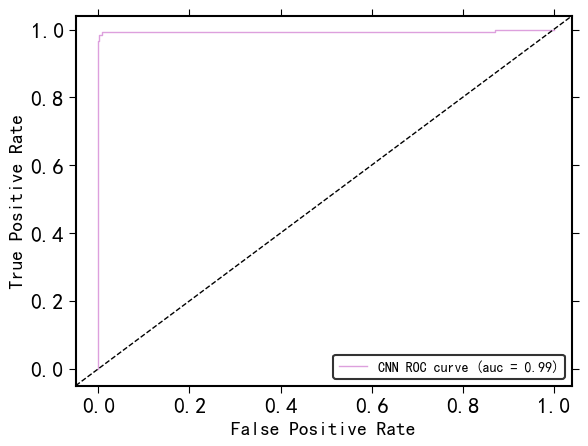

In [46]:
fig, ax = plt.subplots() 
# Plot all ROC curves
ax.plot(fpr_smica["micro"], tpr_smica["micro"],
         label='CNN ROC curve (auc = {0:0.2f})'
               ''.format(roc_auc_smica["micro"]),
         color='plum', linestyle='-', linewidth=1)

plt.plot([-0.05, 1.05], [-0.05, 1.05], 'k--', lw=1)

plt.xlim([-0.05, 1.04])
plt.ylim([-0.05, 1.04])


plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
leg=plt.legend(loc="lower right")
leg.legendPatch.set_linewidth(1.5)
leg.get_frame().set_edgecolor('black')
plt.tick_params(axis='x', which='both', size=5, labelsize=14)  
plt.tick_params(axis='y', which='both', size=5, labelsize=14) 

plt.tick_params(top='on', right='on', which='both') # 显示上侧和右侧的刻度
plt.rcParams['xtick.direction'] = 'in' #将x轴的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in' #将y轴的刻度方向设置向内

SCIPlot()
plt.show()

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

tensor([[ 14.2485, -33.5534, -38.1925,  ..., -30.3394, -21.1684, -30.9722],
        [-23.1768, -24.1604, -34.9827,  ...,  -9.0521, -27.9727, -20.0792],
        [-40.3948, -29.2659, -38.9077,  ..., -32.0851, -30.3396, -26.4124],
        ...,
        [ -8.6453,  -5.6572,  -9.2004,  ...,  -7.9966,  -6.3591,   7.7807],
        [-34.6022, -54.0001, -63.9015,  ..., -46.5403, -52.7813, -52.9683],
        [-47.7105, -42.6003, -61.2382,  ..., -52.1692, -31.1961, -17.5781]])


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

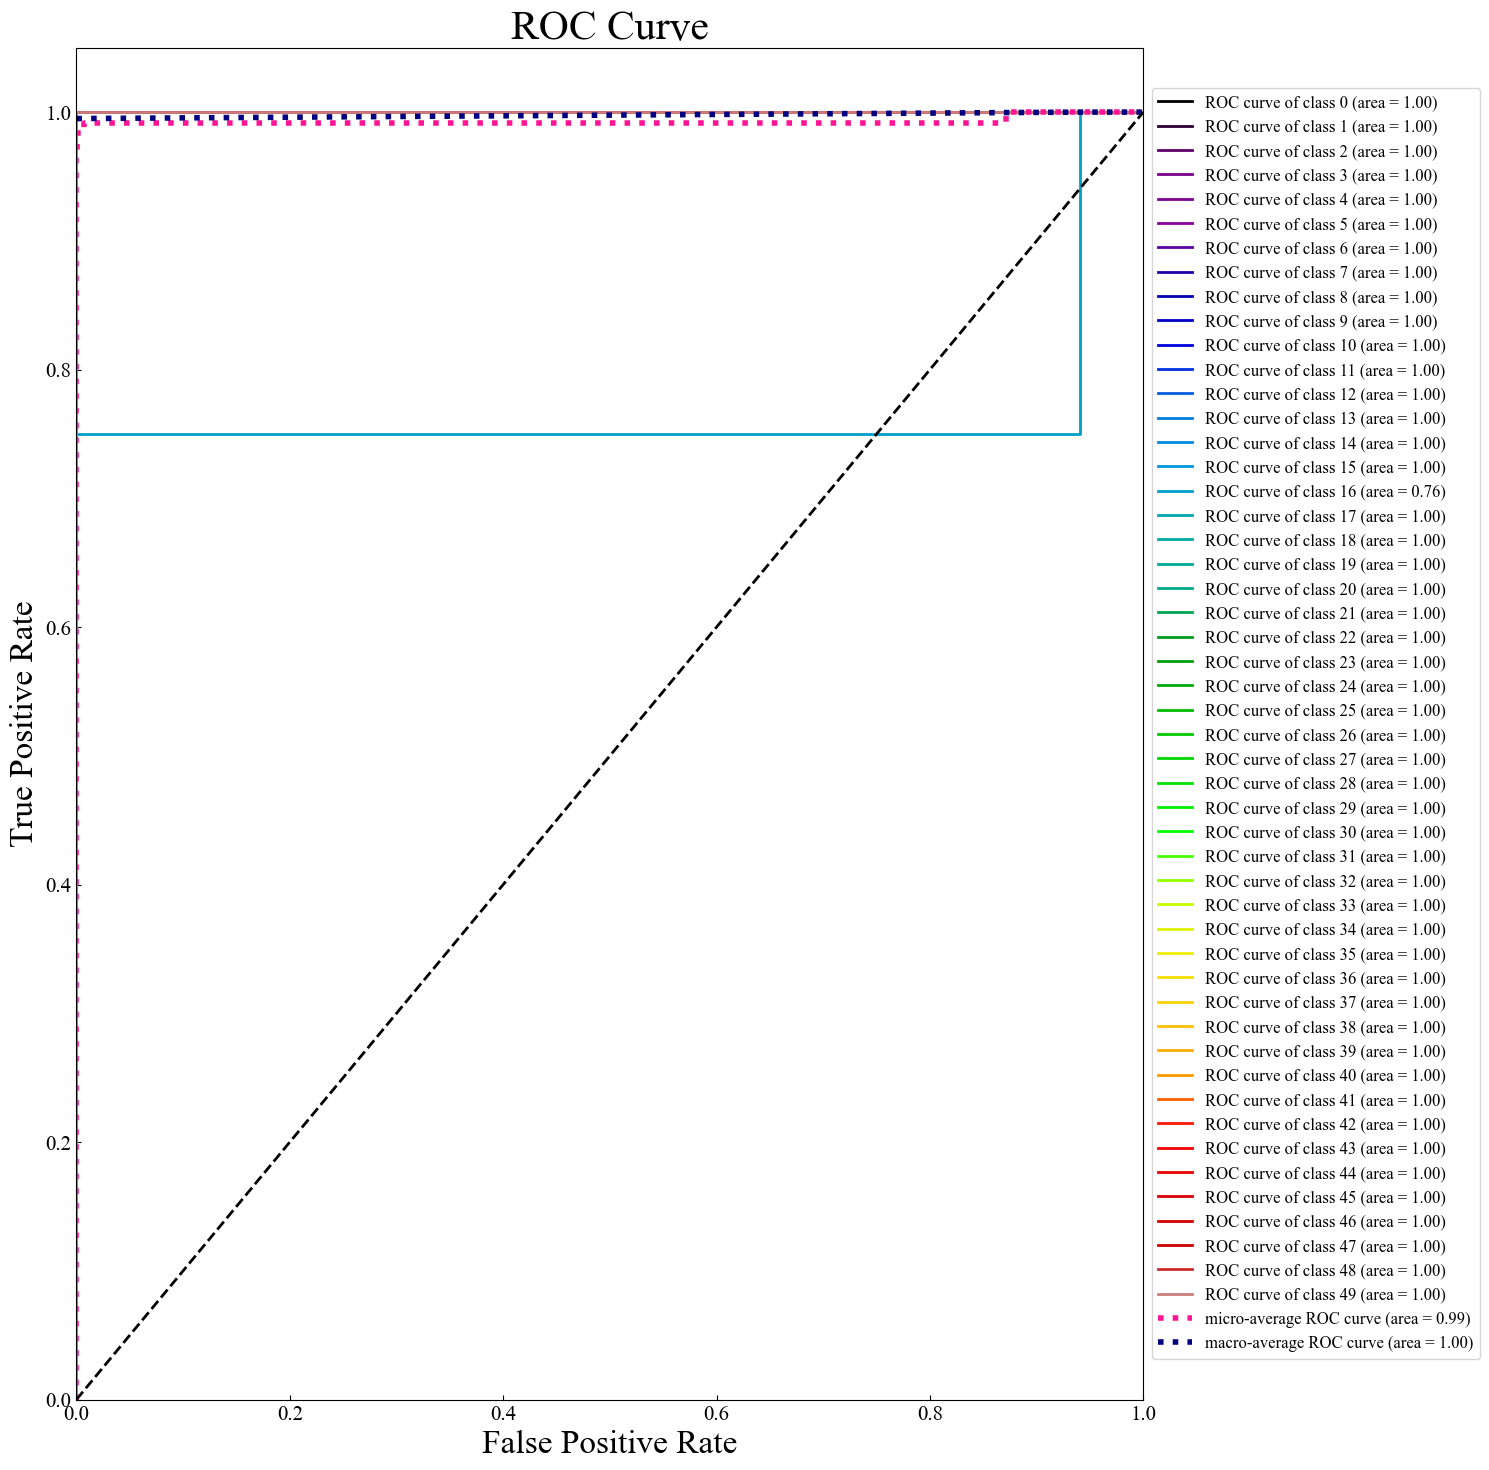

In [88]:
import matplotlib.pyplot as plt
import scikitplot as skplt
y_pred_test = y_pred_proba_smica
print(y_pred_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_test)
plt.gcf().set_size_inches(15, 15)
# 设置标题和轴标签，并修改字体大小
plt.title("ROC Curve", fontsize=30)  # 标题字体大小
plt.xlabel("False Positive Rate", fontsize=24)  # X轴标签字体大小
plt.ylabel("True Positive Rate", fontsize=24)  # Y轴标签字体大小

# 调整刻度标签的字体大小
plt.xticks(fontsize=15)  # X轴刻度标签字体大小
plt.yticks(fontsize=15)  # Y轴刻度标签字体大小

# 调整图例的字体大小，并将图例放置在右侧
plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))  # 图例字体大小，并靠右放置

plt.tight_layout()  # 自动调整布局，避免图例被裁剪

plt.show()  # 显示图形

输出各种指标

In [48]:
#回归问题评价指标
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
#分类问题评价指标
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [49]:
y_pred_test_p=y_pred_test.argmax(1)
np.array(y_pred_test_p)

array([ 0, 42, 32,  6,  5, 33, 18, 42,  8, 37,  6, 14, 35,  4,  8, 40, 25,
       32, 37, 21, 29, 49, 49, 36, 36, 33, 42, 11, 41, 21,  1,  7, 19, 30,
       39, 20, 16,  3,  9, 37, 23, 34, 21, 24, 25, 39,  1, 27, 17, 21, 14,
       12, 48, 39, 39, 21, 29,  5, 46, 35, 24, 19, 15, 20, 40, 38, 47,  3,
       29, 13, 13, 39, 10, 26, 49, 16, 47, 16, 48, 22, 34, 10, 44, 37, 30,
       13, 31, 45, 23, 45, 28, 14, 41, 44,  2,  8,  2,  0, 26, 14, 18,  1,
       27, 31,  8, 43, 35, 43,  6, 40, 15, 28, 48, 28,  9,  8, 22, 28, 26,
       49,  8, 37], dtype=int64)

In [50]:
X_train_torch=torch.from_numpy(X_train)
X_train_torch=torch.reshape(X_train_torch,(-1,1,16001))
X_train_torch=X_train_torch.to(dtype=torch.float)
model.eval()
with torch.no_grad():
    outputs_train_LeNet = best_model(X_train_torch)
print(outputs_train_LeNet)

After conv1 and maxpool1: torch.Size([425, 64, 3998])
After conv2 and maxpool2: torch.Size([425, 64, 3998])
After flatten: torch.Size([425, 255872])
tensor([[-15.4742,  -4.8722, -11.6070,  ..., -12.1751, -13.7587,  -9.1782],
        [ -6.7440,  -2.7269,  -4.0968,  ...,  -5.6199,  -4.5365,  -1.1275],
        [-20.1450, -27.9419, -26.1610,  ..., -16.9075, -11.0302, -19.6342],
        ...,
        [ -9.9902, -12.4221, -12.2272,  ...,  -5.9282,   4.8713, -11.3229],
        [ -9.2013,  -7.1077,  -2.0069,  ...,  -1.5071,  -2.8679,  -4.6455],
        [-10.2733,  -8.7754,  -3.3129,  ...,  -1.7400,  -7.1671,  -6.4837]])


In [51]:
y_pred_train_p=outputs_train_LeNet.argmax(1)
y_pred_train_p

tensor([39, 29, 45, 18, 33, 16, 25, 20, 11, 33, 15,  8, 26, 13, 14, 33,  4, 37,
        39, 36, 15, 14, 21, 43, 18,  3, 41, 16,  2,  8, 15, 14, 21, 35, 28, 44,
        20,  8, 34, 45, 14,  5, 48, 16, 19, 11, 30, 31, 42, 30, 31, 36, 22, 35,
        42, 33, 16, 16, 35,  9, 37, 28, 34, 39, 21, 16,  8,  1, 32,  2, 39, 21,
        39, 35, 27, 13, 11,  0, 24, 49, 33, 12, 25, 44, 39, 39, 25, 47, 12, 46,
        49,  6, 44, 28, 26, 21, 30,  9, 15,  6, 21, 23,  6, 39, 29, 47, 26, 26,
        39, 49, 37, 28,  3, 21, 44, 21, 29, 28,  2, 37, 28, 32,  8, 40, 30, 49,
        40,  8, 46, 41, 13, 32, 42, 43, 37, 14, 29,  6, 36, 24, 35, 21, 41, 43,
         2, 39, 28, 16, 37, 38, 21, 10, 22, 13, 35, 19, 43, 37,  9, 29, 29, 26,
        42,  5, 13, 49,  8, 16, 23, 44, 28, 14, 23, 40, 30, 33, 37,  7, 15, 24,
        39, 37, 19, 18, 37,  8, 24, 12,  5,  4, 14, 35,  0, 35,  7, 45, 14,  9,
        34, 49, 10, 49, 38, 41,  3, 40,  0, 13, 40, 12, 28, 24,  0,  8, 35, 15,
        41, 49, 13, 19, 30, 27,  3,  8, 

In [52]:
accuracy_test=accuracy_score(y_train, y_pred_train_p)
precision_test = precision_score(y_train, y_pred_train_p,average='macro')
recall_test = recall_score(y_train, y_pred_train_p,average='macro')
f1_test = f1_score(y_train, y_pred_train_p,average='macro')
confumatrix_test=confusion_matrix(y_train, y_pred_train_p)
classreport_test=classification_report(y_train, y_pred_train_p)
print("训练集准确度：",accuracy_test)
print("训练集精确度：",precision_test)
print("训练集召回率：",recall_test)
print("训练集f1分数：",f1_test)
print("训练集的混淆矩阵：\n",confumatrix_test)
print("训练集的分类报告：\n",classreport_test)
print("*"*100)

训练集准确度： 0.9905882352941177
训练集精确度： 0.9933333333333334
训练集召回率： 0.9906666666666666
训练集f1分数： 0.9906176142697882
训练集的混淆矩阵：
 [[ 7  0  0 ...  0  0  0]
 [ 0  8  0 ...  0  0  0]
 [ 0  0  6 ...  0  0  0]
 ...
 [ 0  0  0 ...  7  0  0]
 [ 0  0  0 ...  0  6  0]
 [ 0  0  0 ...  0  0 11]]
训练集的分类报告：
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      0.67      0.80         6
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00         7
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         5
          

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

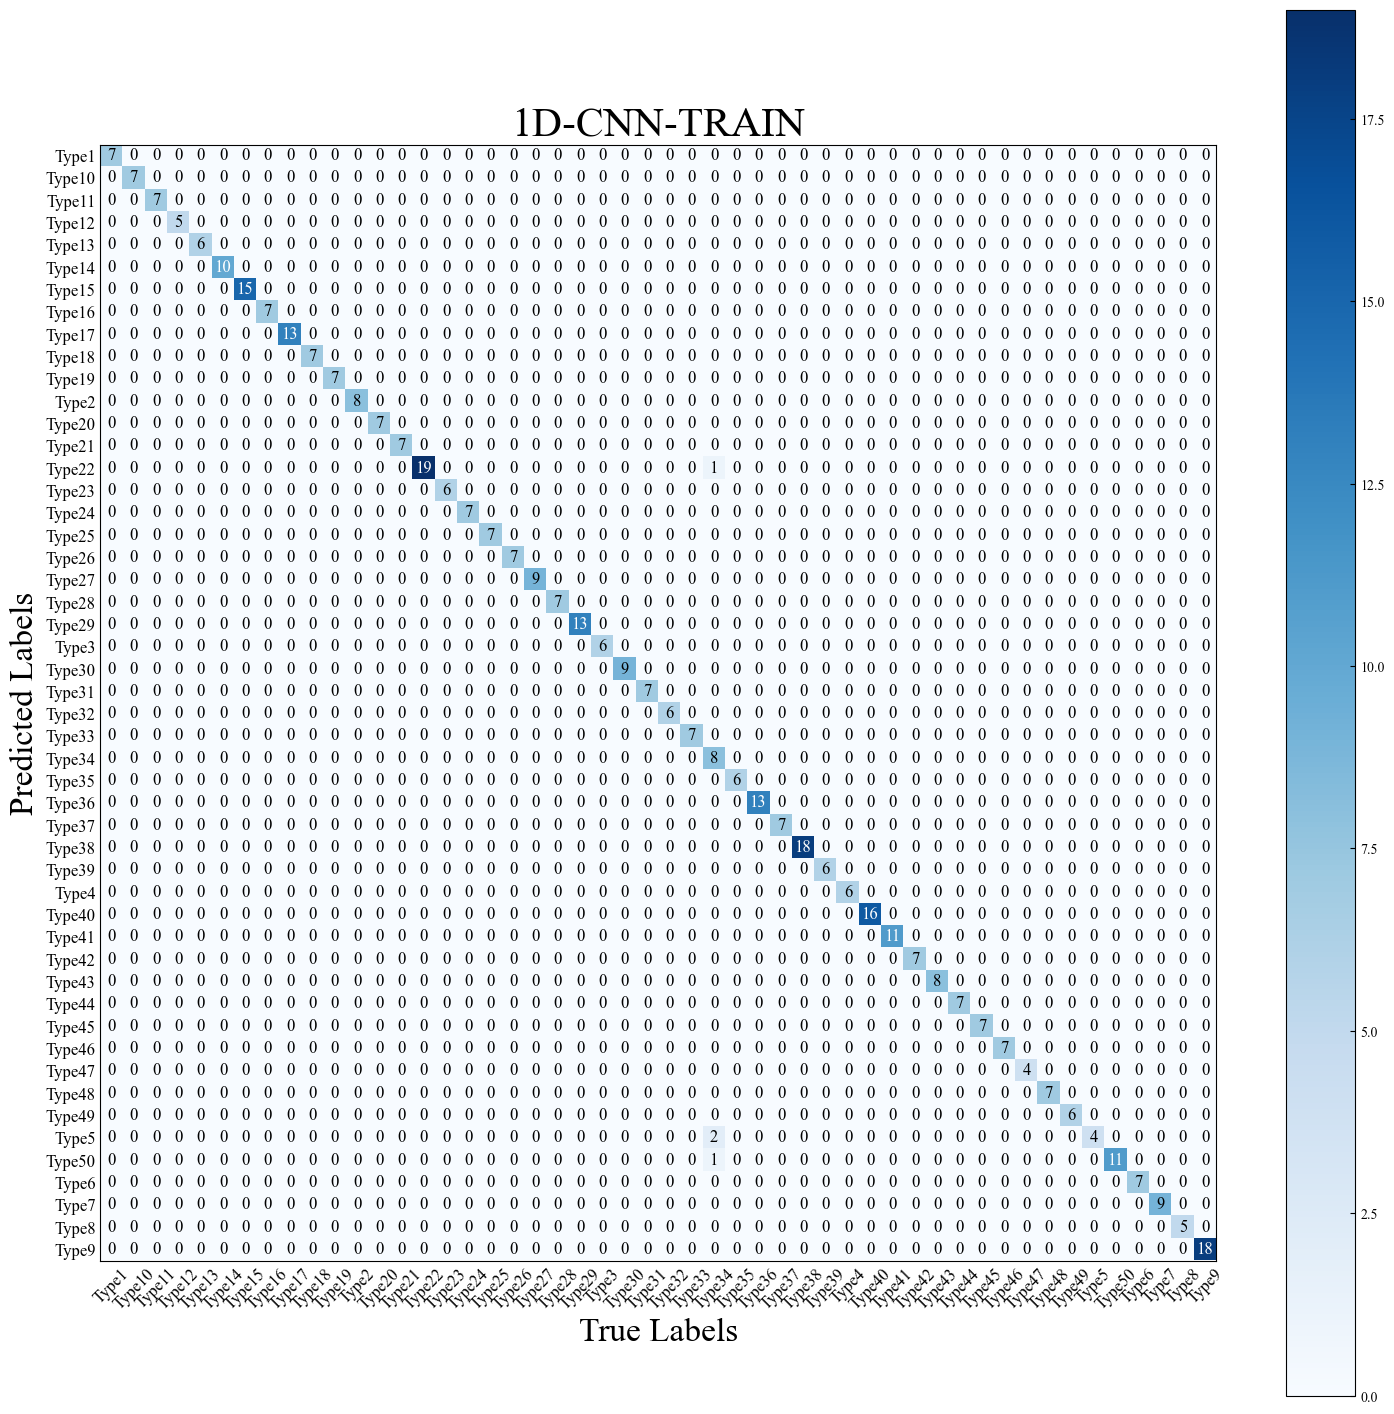

In [103]:
mapping = { 
    0: 'Type1',
    1: 'Type2',
    2: 'Type3',
    3: 'Type4', 
    4: 'Type5',
    5: 'Type6',
    6: 'Type7',
    7: 'Type8',
    8: 'Type9',
    9: 'Type10',
    10: 'Type11',
    11: 'Type12',
    12: 'Type13',
    13: 'Type14',
    14: 'Type15',
    15: 'Type16',
    16: 'Type17',
    17: 'Type18',
    18: 'Type19',
    19: 'Type20',
    20: 'Type21',
    21: 'Type22',
    22: 'Type23',
    23: 'Type24',
    24: 'Type25',
    25: 'Type26',
    26: 'Type27',
    27: 'Type28',
    28: 'Type29',
    29: 'Type30',
    30: 'Type31',
    31: 'Type32',
    32: 'Type33',
    33: 'Type34',
    34: 'Type35',
    35: 'Type36',
    36: 'Type37',
    37: 'Type38',
    38: 'Type39',
    39: 'Type40',
    40: 'Type41',
    41: 'Type42',
    42: 'Type43',
    43: 'Type44',
    44: 'Type45',
    45: 'Type46',
    46: 'Type47',
    47: 'Type48',
    48: 'Type49',
    49: 'Type50',


    
} 

y_train_= [mapping[i] if i in mapping else i for i in y_train] 
y_pred_train_ = [mapping[i] if i in mapping else i for i in np.array(y_pred_train_p)] 
plot = skplt.metrics.plot_confusion_matrix(y_train_, y_pred_train_,x_tick_rotation=45,text_fontsize=12,figsize=(18,18))
# 设置标题和轴标题的字体大小
plt.title('1D-CNN-TRAIN', fontsize=30)  # 设置标题的字体大小
plt.xlabel('True Labels', fontsize=24)  # 设置X轴标题的字体大小
plt.ylabel('Predicted Labels', fontsize=24)  # 设置Y轴标题的字体大小
plt.tick_params(axis='both', which='both', length=0)  
plt.savefig('random forest all.png', dpi=800,bbox_inches='tight') 
plt.grid(False)
plt.show()

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

tensor([[ 14.2485, -33.5534, -38.1925,  ..., -30.3394, -21.1684, -30.9722],
        [-23.1768, -24.1604, -34.9827,  ...,  -9.0521, -27.9727, -20.0792],
        [-40.3948, -29.2659, -38.9077,  ..., -32.0851, -30.3396, -26.4124],
        ...,
        [ -8.6453,  -5.6572,  -9.2004,  ...,  -7.9966,  -6.3591,   7.7807],
        [-34.6022, -54.0001, -63.9015,  ..., -46.5403, -52.7813, -52.9683],
        [-47.7105, -42.6003, -61.2382,  ..., -52.1692, -31.1961, -17.5781]])


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

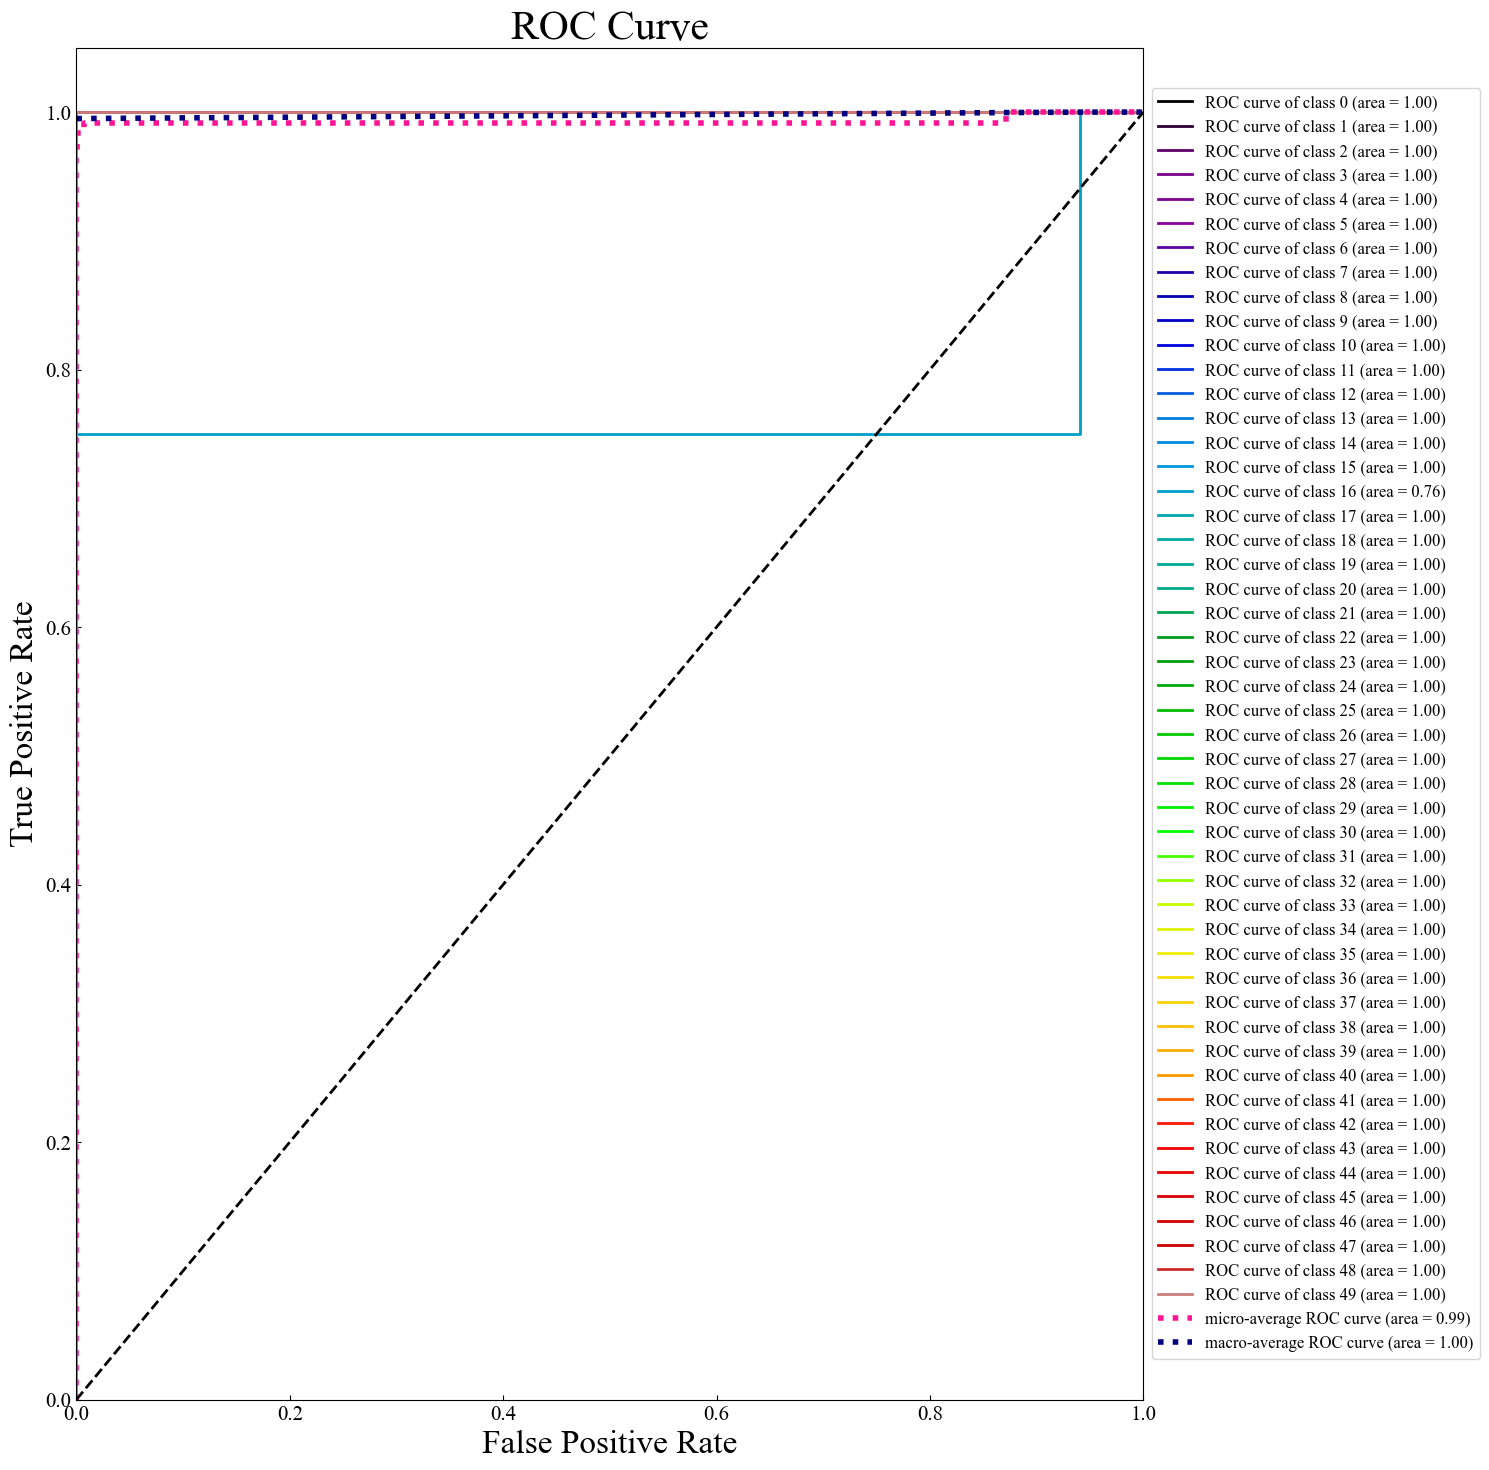

In [ ]:
import matplotlib.pyplot as plt
import scikitplot as skplt
y_pred_test = y_pred_proba_smica
print(y_pred_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_test)
plt.gcf().set_size_inches(15, 15)
# 设置标题和轴标签，并修改字体大小
plt.title("ROC Curve", fontsize=30)  # 标题字体大小
plt.xlabel("False Positive Rate", fontsize=24)  # X轴标签字体大小
plt.ylabel("True Positive Rate", fontsize=24)  # Y轴标签字体大小

# 调整刻度标签的字体大小
plt.xticks(fontsize=15)  # X轴刻度标签字体大小
plt.yticks(fontsize=15)  # Y轴刻度标签字体大小

# 调整图例的字体大小，并将图例放置在右侧
plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))  # 图例字体大小，并靠右放置

plt.tight_layout()  # 自动调整布局，避免图例被裁剪

plt.show()  # 显示图形

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

tensor([[ 14.2485, -33.5534, -38.1925,  ..., -30.3394, -21.1684, -30.9722],
        [-23.1768, -24.1604, -34.9827,  ...,  -9.0521, -27.9727, -20.0792],
        [-40.3948, -29.2659, -38.9077,  ..., -32.0851, -30.3396, -26.4124],
        ...,
        [ -8.6453,  -5.6572,  -9.2004,  ...,  -7.9966,  -6.3591,   7.7807],
        [-34.6022, -54.0001, -63.9015,  ..., -46.5403, -52.7813, -52.9683],
        [-47.7105, -42.6003, -61.2382,  ..., -52.1692, -31.1961, -17.5781]])


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

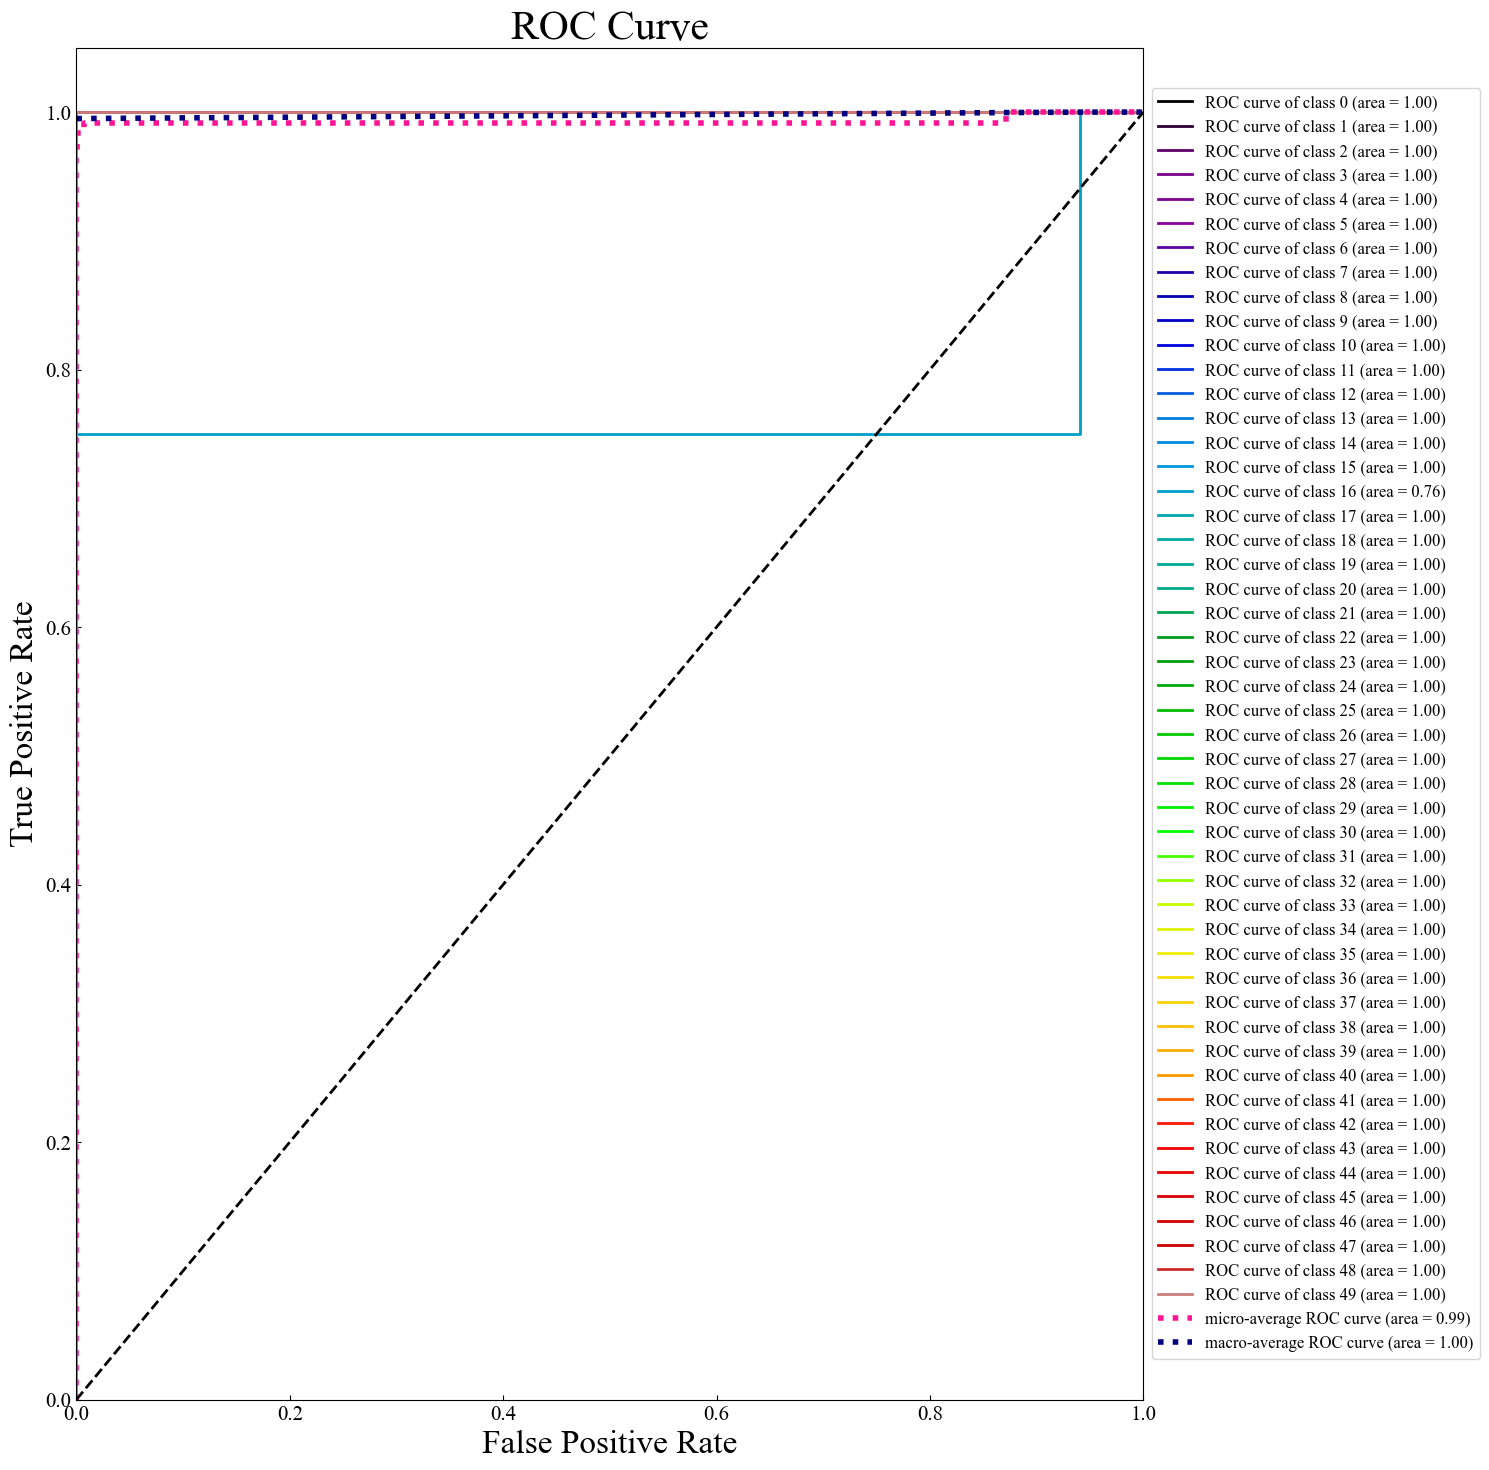

In [ ]:
import matplotlib.pyplot as plt
import scikitplot as skplt
y_pred_test = y_pred_proba_smica
print(y_pred_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_test)
plt.gcf().set_size_inches(15, 15)
# 设置标题和轴标签，并修改字体大小
plt.title("ROC Curve", fontsize=30)  # 标题字体大小
plt.xlabel("False Positive Rate", fontsize=24)  # X轴标签字体大小
plt.ylabel("True Positive Rate", fontsize=24)  # Y轴标签字体大小

# 调整刻度标签的字体大小
plt.xticks(fontsize=15)  # X轴刻度标签字体大小
plt.yticks(fontsize=15)  # Y轴刻度标签字体大小

# 调整图例的字体大小，并将图例放置在右侧
plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))  # 图例字体大小，并靠右放置

plt.tight_layout()  # 自动调整布局，避免图例被裁剪

plt.show()  # 显示图形

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

tensor([[ 14.2485, -33.5534, -38.1925,  ..., -30.3394, -21.1684, -30.9722],
        [-23.1768, -24.1604, -34.9827,  ...,  -9.0521, -27.9727, -20.0792],
        [-40.3948, -29.2659, -38.9077,  ..., -32.0851, -30.3396, -26.4124],
        ...,
        [ -8.6453,  -5.6572,  -9.2004,  ...,  -7.9966,  -6.3591,   7.7807],
        [-34.6022, -54.0001, -63.9015,  ..., -46.5403, -52.7813, -52.9683],
        [-47.7105, -42.6003, -61.2382,  ..., -52.1692, -31.1961, -17.5781]])


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

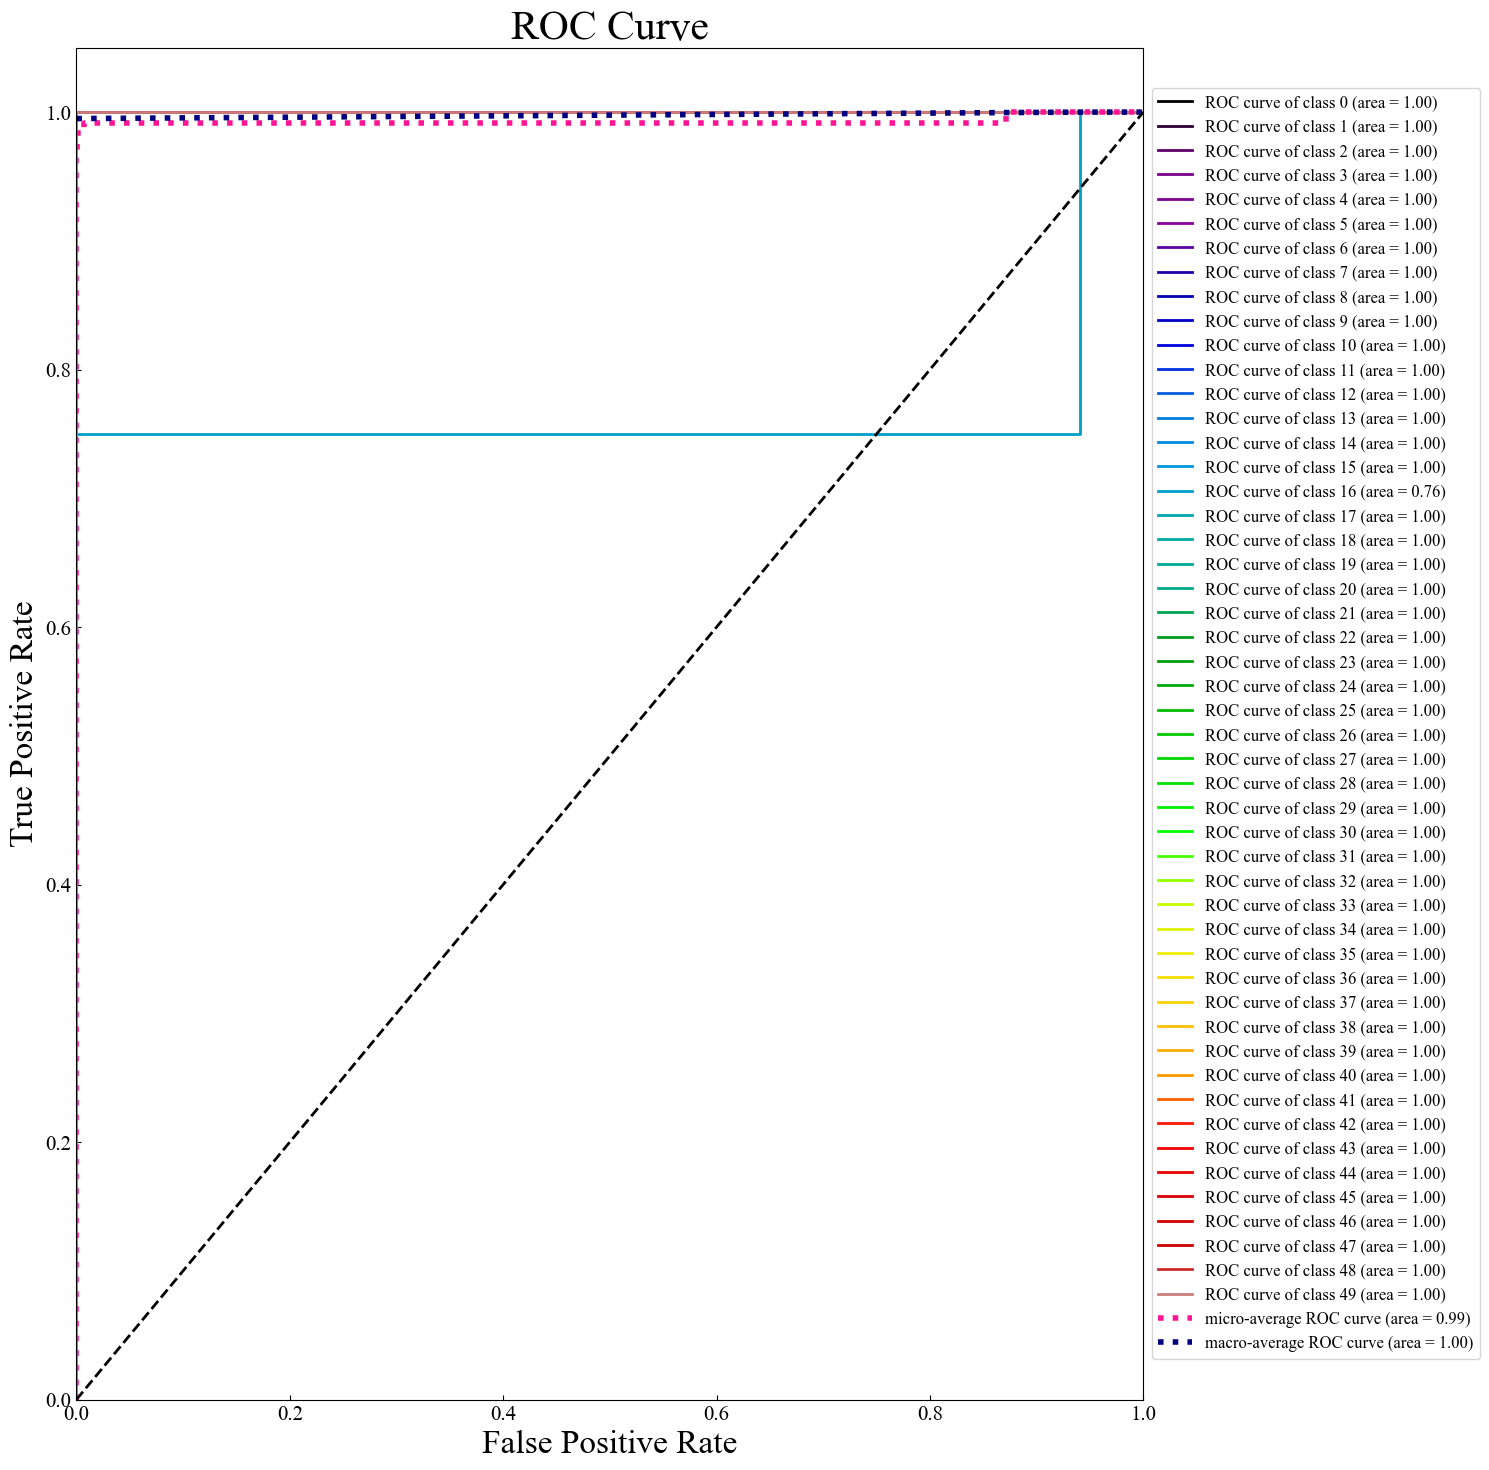

In [ ]:
import matplotlib.pyplot as plt
import scikitplot as skplt
y_pred_test = y_pred_proba_smica
print(y_pred_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_test)
plt.gcf().set_size_inches(15, 15)
# 设置标题和轴标签，并修改字体大小
plt.title("ROC Curve", fontsize=30)  # 标题字体大小
plt.xlabel("False Positive Rate", fontsize=24)  # X轴标签字体大小
plt.ylabel("True Positive Rate", fontsize=24)  # Y轴标签字体大小

# 调整刻度标签的字体大小
plt.xticks(fontsize=15)  # X轴刻度标签字体大小
plt.yticks(fontsize=15)  # Y轴刻度标签字体大小

# 调整图例的字体大小，并将图例放置在右侧
plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))  # 图例字体大小，并靠右放置

plt.tight_layout()  # 自动调整布局，避免图例被裁剪

plt.show()  # 显示图形

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

tensor([[ 14.2485, -33.5534, -38.1925,  ..., -30.3394, -21.1684, -30.9722],
        [-23.1768, -24.1604, -34.9827,  ...,  -9.0521, -27.9727, -20.0792],
        [-40.3948, -29.2659, -38.9077,  ..., -32.0851, -30.3396, -26.4124],
        ...,
        [ -8.6453,  -5.6572,  -9.2004,  ...,  -7.9966,  -6.3591,   7.7807],
        [-34.6022, -54.0001, -63.9015,  ..., -46.5403, -52.7813, -52.9683],
        [-47.7105, -42.6003, -61.2382,  ..., -52.1692, -31.1961, -17.5781]])


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

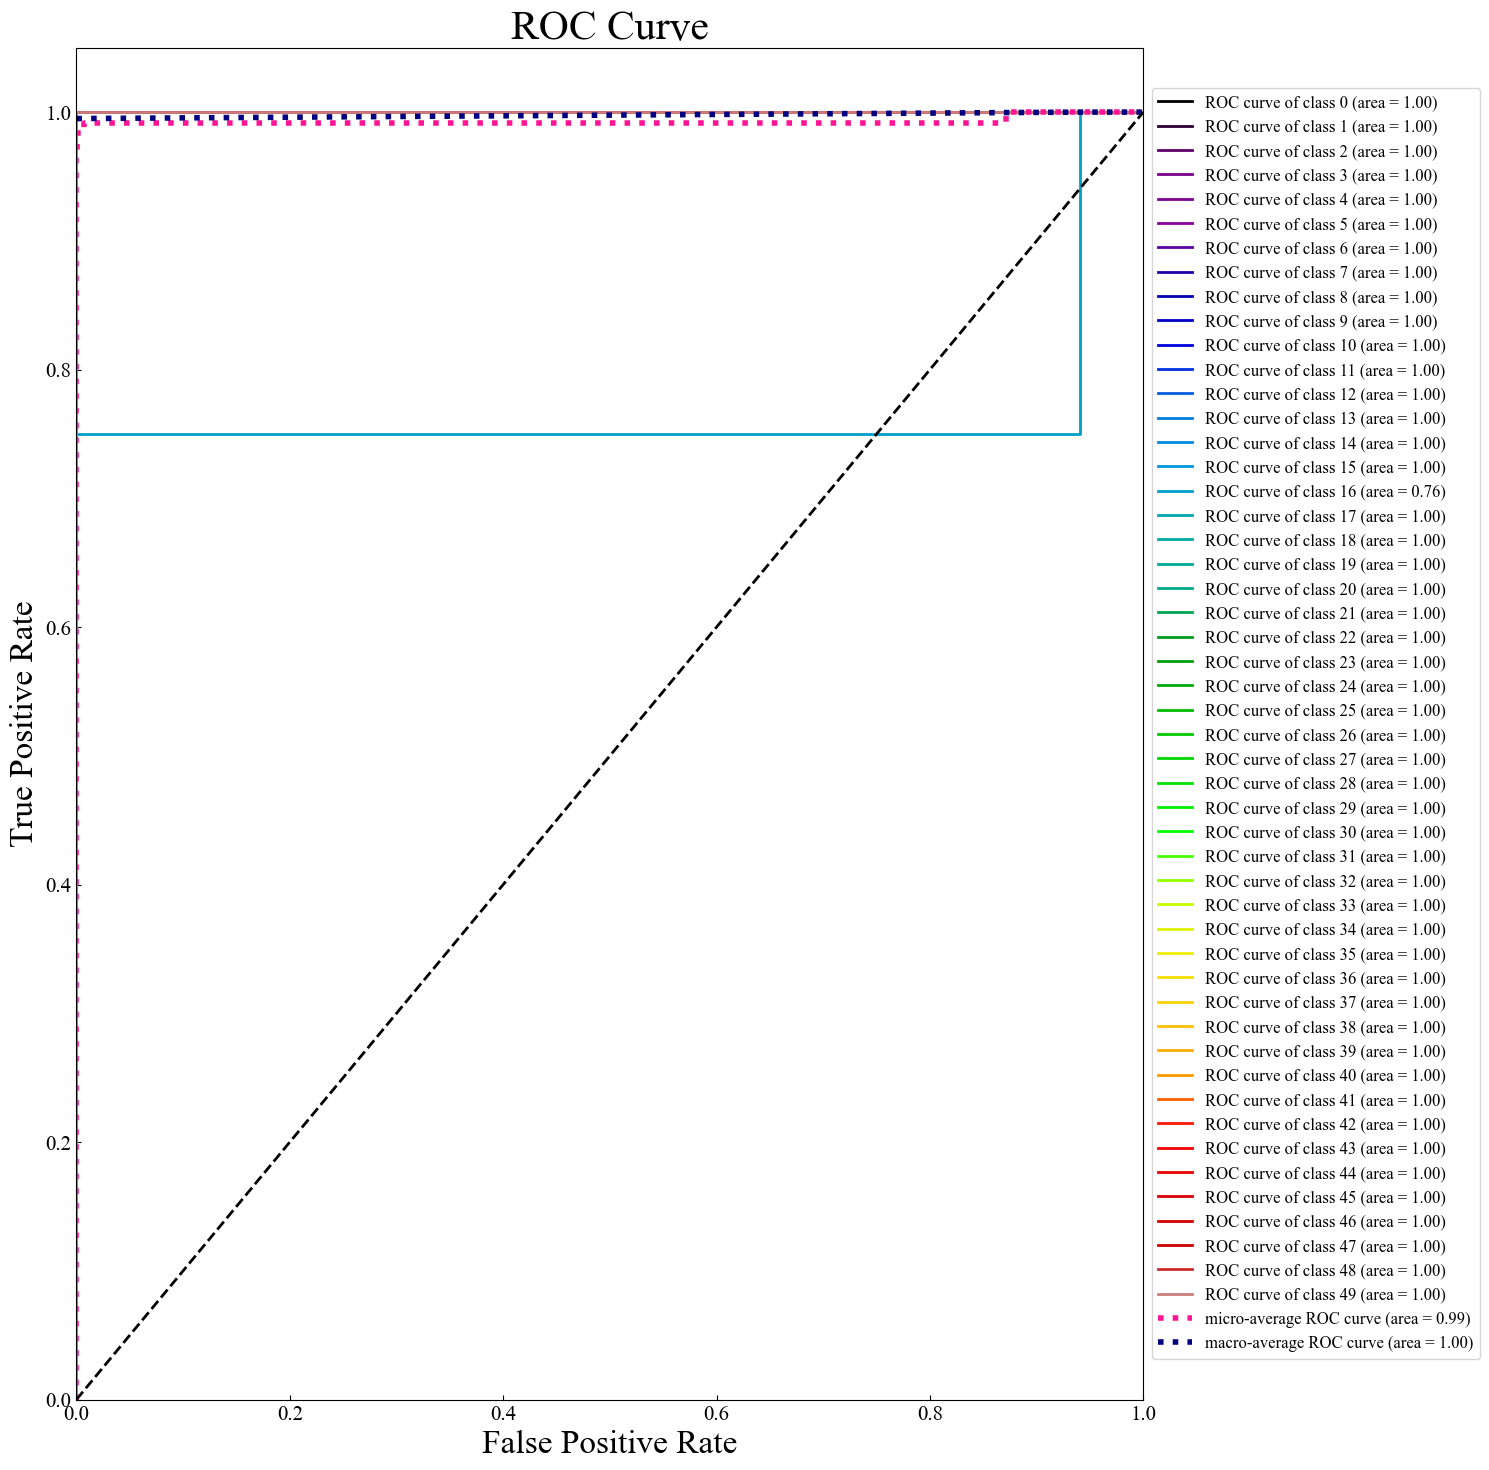

In [ ]:
import matplotlib.pyplot as plt
import scikitplot as skplt
y_pred_test = y_pred_proba_smica
print(y_pred_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_test)
plt.gcf().set_size_inches(15, 15)
# 设置标题和轴标签，并修改字体大小
plt.title("ROC Curve", fontsize=30)  # 标题字体大小
plt.xlabel("False Positive Rate", fontsize=24)  # X轴标签字体大小
plt.ylabel("True Positive Rate", fontsize=24)  # Y轴标签字体大小

# 调整刻度标签的字体大小
plt.xticks(fontsize=15)  # X轴刻度标签字体大小
plt.yticks(fontsize=15)  # Y轴刻度标签字体大小

# 调整图例的字体大小，并将图例放置在右侧
plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))  # 图例字体大小，并靠右放置

plt.tight_layout()  # 自动调整布局，避免图例被裁剪

plt.show()  # 显示图形

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

tensor([[ 14.2485, -33.5534, -38.1925,  ..., -30.3394, -21.1684, -30.9722],
        [-23.1768, -24.1604, -34.9827,  ...,  -9.0521, -27.9727, -20.0792],
        [-40.3948, -29.2659, -38.9077,  ..., -32.0851, -30.3396, -26.4124],
        ...,
        [ -8.6453,  -5.6572,  -9.2004,  ...,  -7.9966,  -6.3591,   7.7807],
        [-34.6022, -54.0001, -63.9015,  ..., -46.5403, -52.7813, -52.9683],
        [-47.7105, -42.6003, -61.2382,  ..., -52.1692, -31.1961, -17.5781]])


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

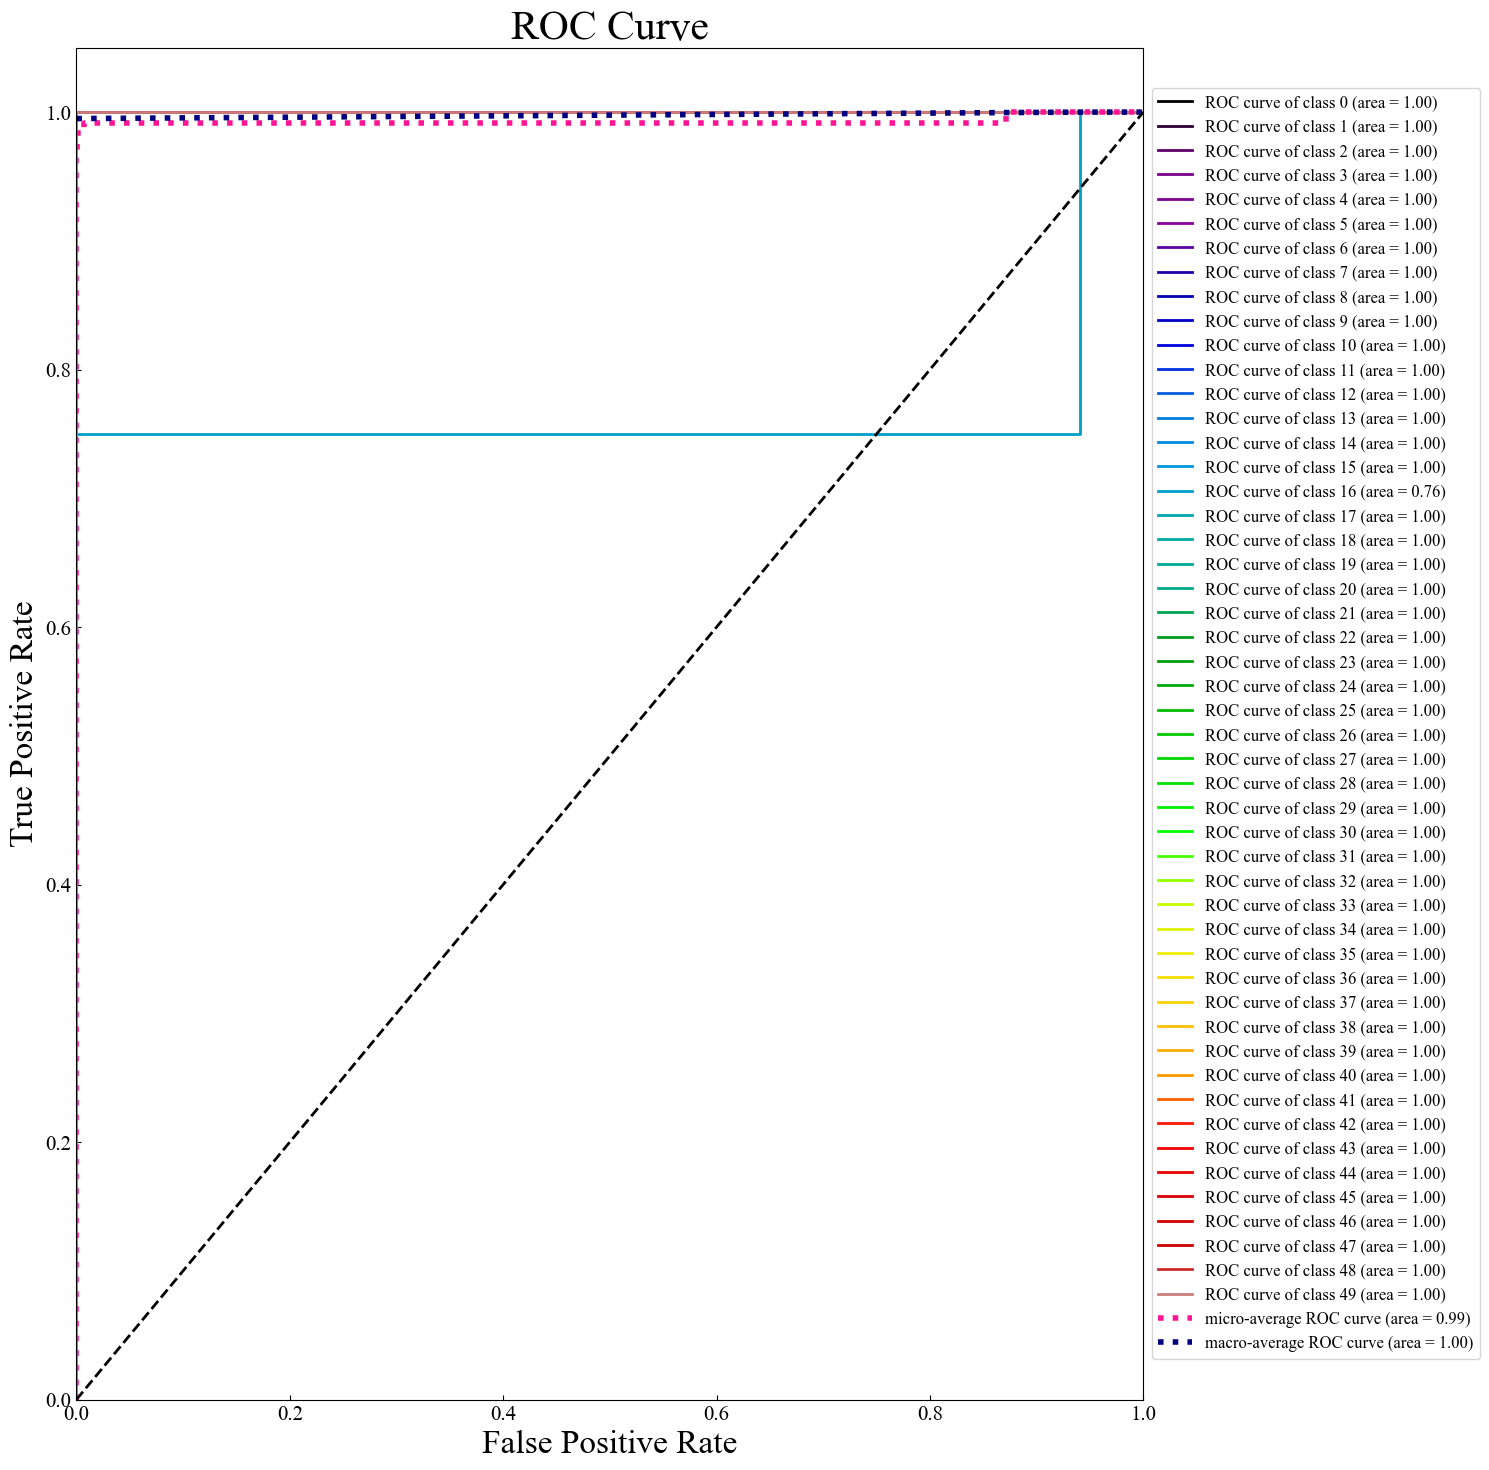

In [ ]:
import matplotlib.pyplot as plt
import scikitplot as skplt
y_pred_test = y_pred_proba_smica
print(y_pred_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_test)
plt.gcf().set_size_inches(15, 15)
# 设置标题和轴标签，并修改字体大小
plt.title("ROC Curve", fontsize=30)  # 标题字体大小
plt.xlabel("False Positive Rate", fontsize=24)  # X轴标签字体大小
plt.ylabel("True Positive Rate", fontsize=24)  # Y轴标签字体大小

# 调整刻度标签的字体大小
plt.xticks(fontsize=15)  # X轴刻度标签字体大小
plt.yticks(fontsize=15)  # Y轴刻度标签字体大小

# 调整图例的字体大小，并将图例放置在右侧
plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))  # 图例字体大小，并靠右放置

plt.tight_layout()  # 自动调整布局，避免图例被裁剪

plt.show()  # 显示图形

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

tensor([[ 14.2485, -33.5534, -38.1925,  ..., -30.3394, -21.1684, -30.9722],
        [-23.1768, -24.1604, -34.9827,  ...,  -9.0521, -27.9727, -20.0792],
        [-40.3948, -29.2659, -38.9077,  ..., -32.0851, -30.3396, -26.4124],
        ...,
        [ -8.6453,  -5.6572,  -9.2004,  ...,  -7.9966,  -6.3591,   7.7807],
        [-34.6022, -54.0001, -63.9015,  ..., -46.5403, -52.7813, -52.9683],
        [-47.7105, -42.6003, -61.2382,  ..., -52.1692, -31.1961, -17.5781]])


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

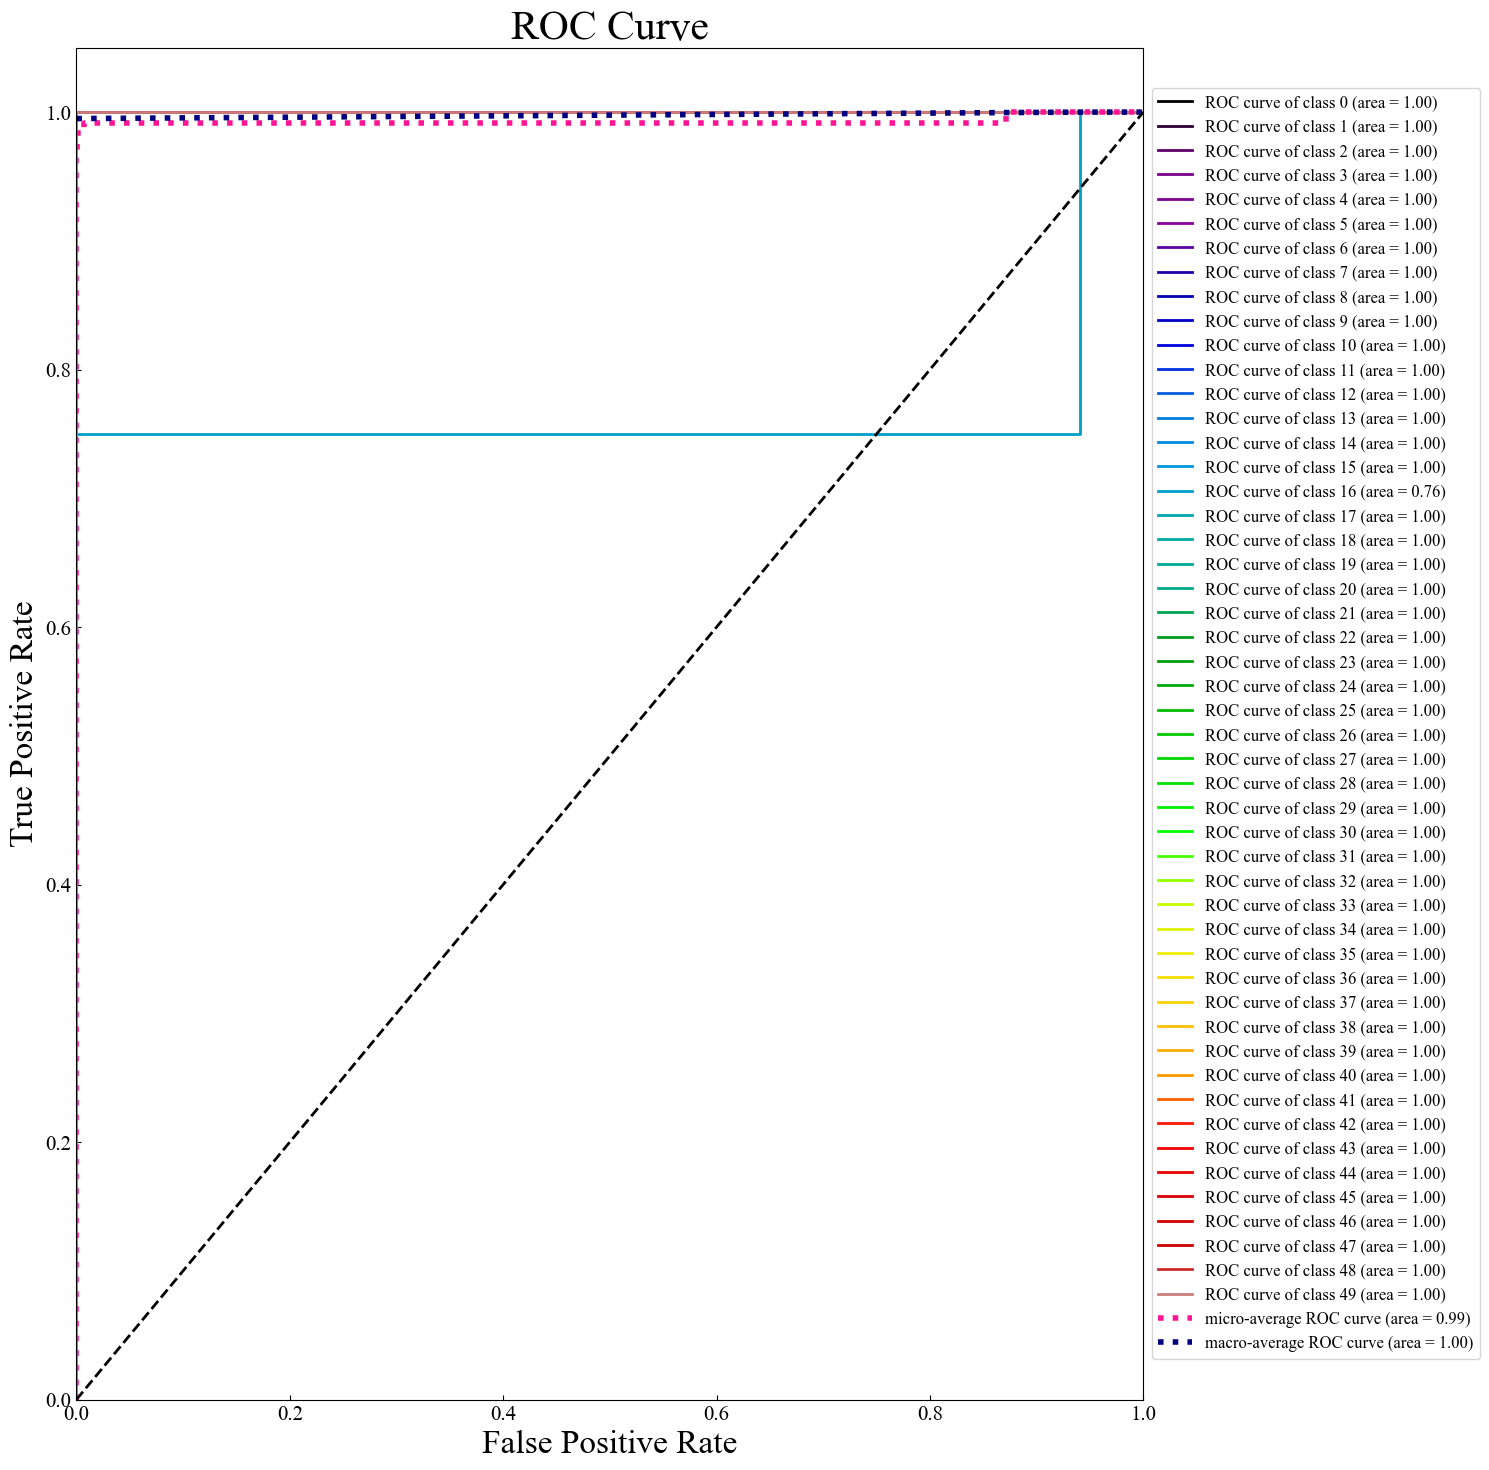

In [ ]:
import matplotlib.pyplot as plt
import scikitplot as skplt
y_pred_test = y_pred_proba_smica
print(y_pred_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_test)
plt.gcf().set_size_inches(15, 15)
# 设置标题和轴标签，并修改字体大小
plt.title("ROC Curve", fontsize=30)  # 标题字体大小
plt.xlabel("False Positive Rate", fontsize=24)  # X轴标签字体大小
plt.ylabel("True Positive Rate", fontsize=24)  # Y轴标签字体大小

# 调整刻度标签的字体大小
plt.xticks(fontsize=15)  # X轴刻度标签字体大小
plt.yticks(fontsize=15)  # Y轴刻度标签字体大小

# 调整图例的字体大小，并将图例放置在右侧
plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))  # 图例字体大小，并靠右放置

plt.tight_layout()  # 自动调整布局，避免图例被裁剪

plt.show()  # 显示图形

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

tensor([[ 14.2485, -33.5534, -38.1925,  ..., -30.3394, -21.1684, -30.9722],
        [-23.1768, -24.1604, -34.9827,  ...,  -9.0521, -27.9727, -20.0792],
        [-40.3948, -29.2659, -38.9077,  ..., -32.0851, -30.3396, -26.4124],
        ...,
        [ -8.6453,  -5.6572,  -9.2004,  ...,  -7.9966,  -6.3591,   7.7807],
        [-34.6022, -54.0001, -63.9015,  ..., -46.5403, -52.7813, -52.9683],
        [-47.7105, -42.6003, -61.2382,  ..., -52.1692, -31.1961, -17.5781]])


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

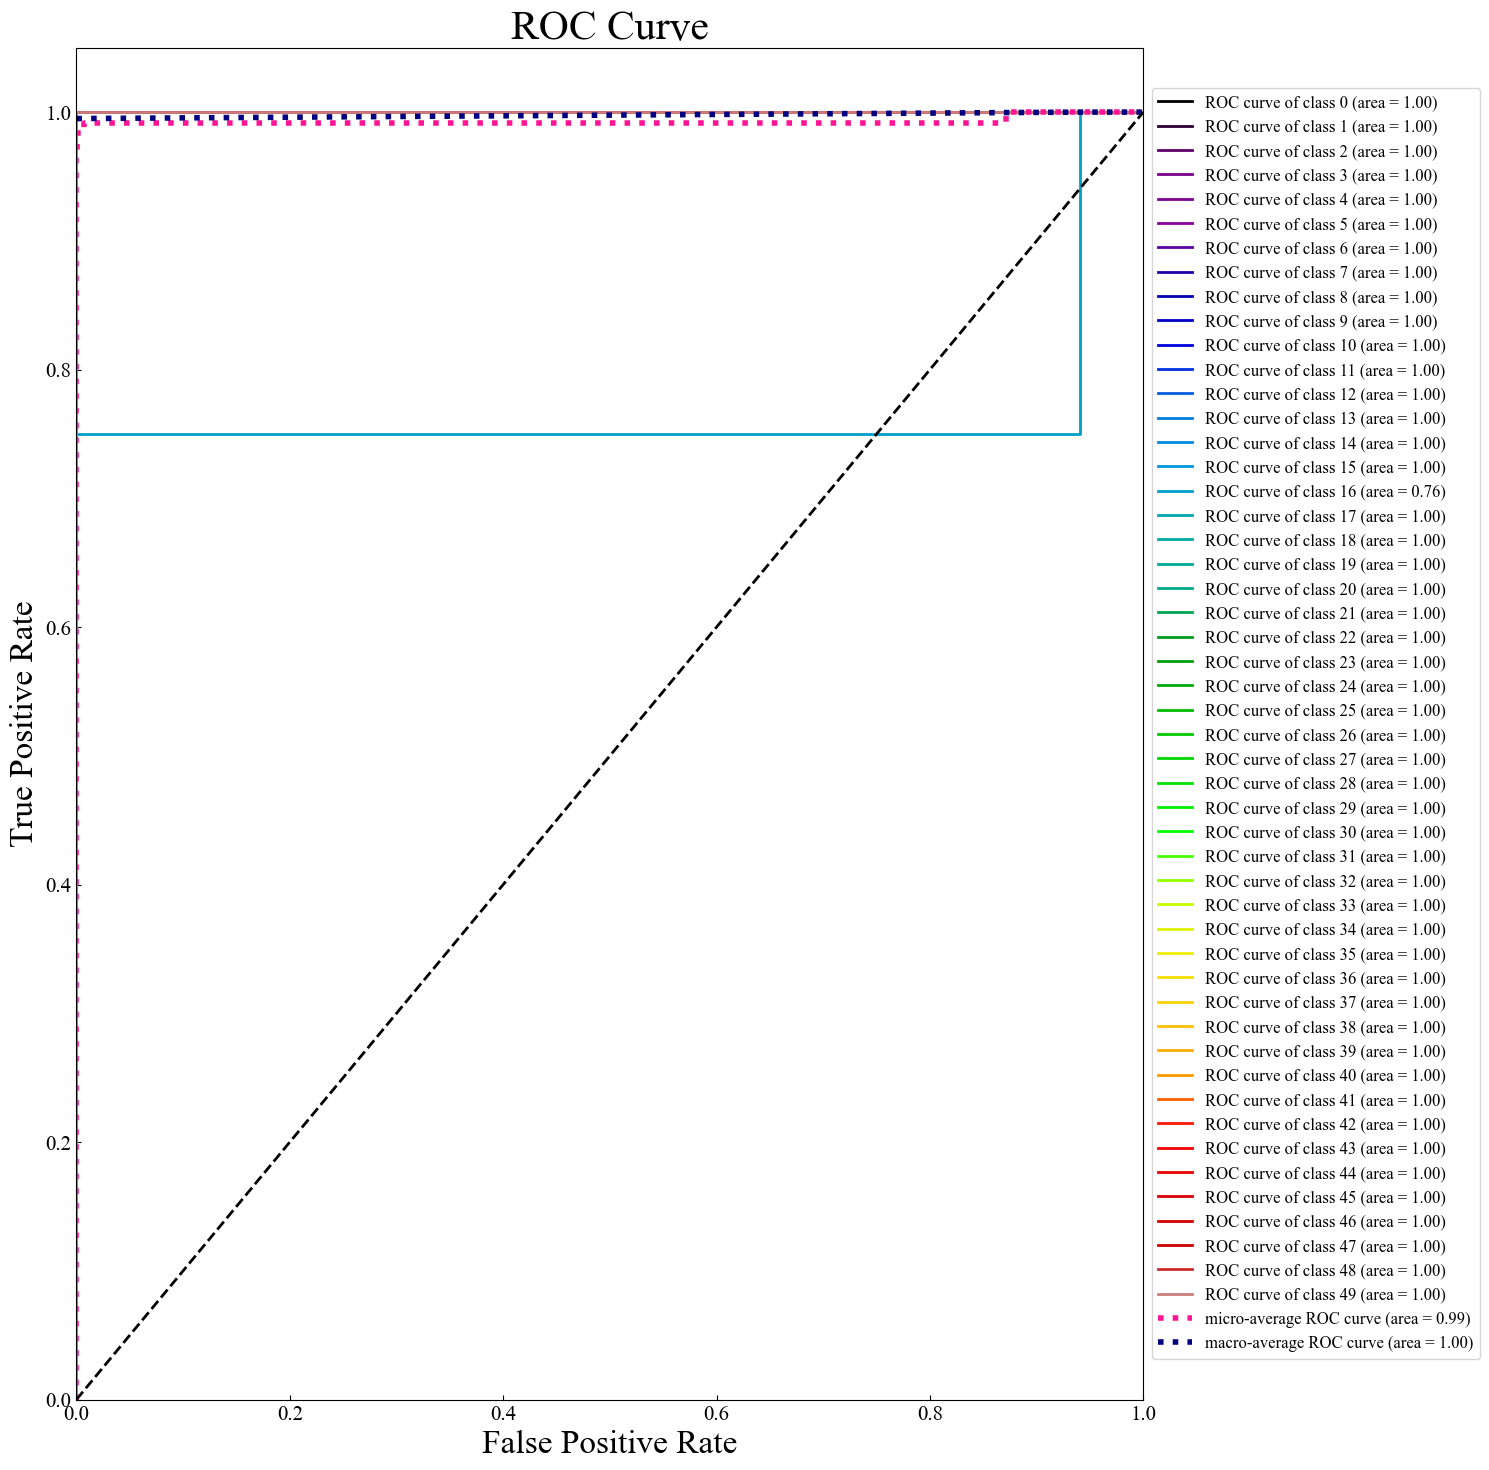

In [ ]:
import matplotlib.pyplot as plt
import scikitplot as skplt
y_pred_test = y_pred_proba_smica
print(y_pred_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_test)
plt.gcf().set_size_inches(15, 15)
# 设置标题和轴标签，并修改字体大小
plt.title("ROC Curve", fontsize=30)  # 标题字体大小
plt.xlabel("False Positive Rate", fontsize=24)  # X轴标签字体大小
plt.ylabel("True Positive Rate", fontsize=24)  # Y轴标签字体大小

# 调整刻度标签的字体大小
plt.xticks(fontsize=15)  # X轴刻度标签字体大小
plt.yticks(fontsize=15)  # Y轴刻度标签字体大小

# 调整图例的字体大小，并将图例放置在右侧
plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))  # 图例字体大小，并靠右放置

plt.tight_layout()  # 自动调整布局，避免图例被裁剪

plt.show()  # 显示图形

In [54]:
accuracy_test=accuracy_score(y_test, y_pred_test_p)
precision_test = precision_score(y_test, y_pred_test_p,average='macro')
recall_test = recall_score(y_test, y_pred_test_p,average='macro')
f1_test = f1_score(y_test, y_pred_test_p,average='macro')
confumatrix_test=confusion_matrix(y_test, y_pred_test_p)
classreport_test=classification_report(y_test, y_pred_test_p)
print("测试集准确度：",accuracy_test)
print("测试集精确度：",precision_test)
print("测试集召回率：",recall_test)
print("测试集f1分数：",f1_test)
print("测试集的混淆矩阵：\n",confumatrix_test)
print("测试集的分类报告：\n",classreport_test)
print("*"*100)

测试集准确度： 0.9754098360655737
测试集精确度： 0.9783333333333333
测试集召回率： 0.975
测试集f1分数： 0.9736190476190475
测试集的混淆矩阵：
 [[2 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 3]]
测试集的分类报告：
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
     

绘制混淆矩阵

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

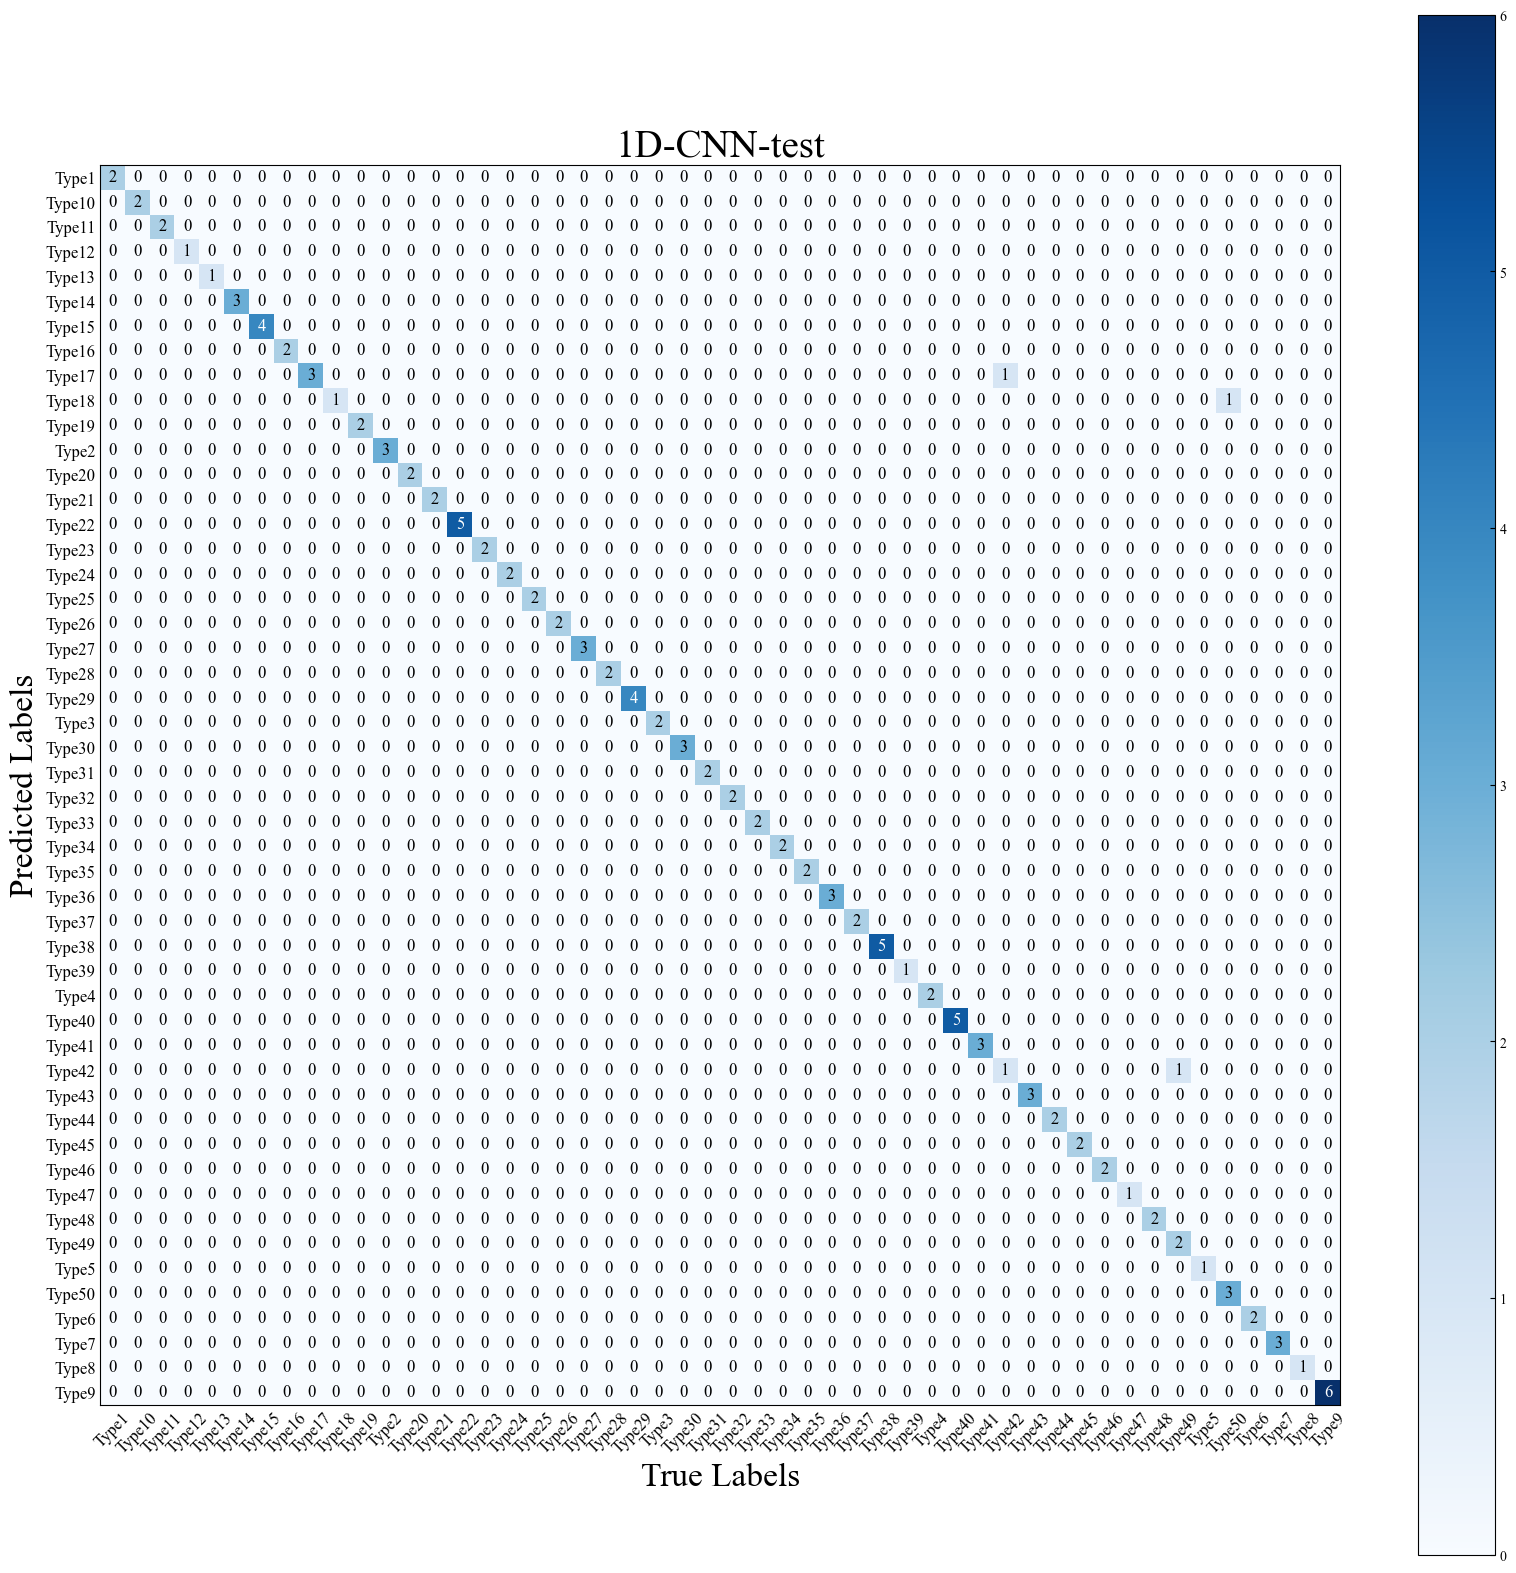

In [100]:
mapping = { 
    0: 'Type1',
    1: 'Type2',
    2: 'Type3',
    3: 'Type4', 
    4: 'Type5',
    5: 'Type6',
    6: 'Type7',
    7: 'Type8',
    8: 'Type9',
    9: 'Type10',
    10: 'Type11',
    11: 'Type12',
    12: 'Type13',
    13: 'Type14',
    14: 'Type15',
    15: 'Type16',
    16: 'Type17',
    17: 'Type18',
    18: 'Type19',
    19: 'Type20',
    20: 'Type21',
    21: 'Type22',
    22: 'Type23',
    23: 'Type24',
    24: 'Type25',
    25: 'Type26',
    26: 'Type27',
    27: 'Type28',
    28: 'Type29',
    29: 'Type30',
    30: 'Type31',
    31: 'Type32',
    32: 'Type33',
    33: 'Type34',
    34: 'Type35',
    35: 'Type36',
    36: 'Type37',
    37: 'Type38',
    38: 'Type39',
    39: 'Type40',
    40: 'Type41',
    41: 'Type42',
    42: 'Type43',
    43: 'Type44',
    44: 'Type45',
    45: 'Type46',
    46: 'Type47',
    47: 'Type48',
    48: 'Type49',
    49: 'Type50',


    
} 


y_test_= [mapping[i] if i in mapping else i for i in y_test] 
y_pred_test_ = [mapping[i] if i in mapping else i for i in np.array(y_pred_test_p)] 
plot = skplt.metrics.plot_confusion_matrix(y_test_, y_pred_test_,x_tick_rotation=45,text_fontsize=12,figsize=(20,20))
# 设置标题和轴标题的字体大小
plt.title('1D-CNN-TEXT', fontsize=28)  # 设置标题的字体大小
plt.xlabel('True Labels', fontsize=24)  # 设置X轴标题的字体大小
plt.ylabel('Predicted Labels', fontsize=24)  # 设置Y轴标题的字体大小
plt.tick_params(axis='both', which='both', length=0)  
plt.savefig('random forest all.png', dpi=800,bbox_inches='tight') 
plt.grid(False)
plt.show()

In [56]:
data=pd.read_excel(r'C:\Users\唐梓竣\Desktop\20241212test\result.xlsx')

In [57]:
X_outer=data.iloc[:,1:-1].values
y_outer=data.iloc[:,-1].values

In [58]:
X_outer_torch=torch.from_numpy(X_outer)
X_outer_torch=torch.reshape(X_outer_torch,(-1,1,16001))
X_outer_torch=X_outer_torch.to(dtype=torch.float)
model.eval()
with torch.no_grad():
    outputs_outer = best_model(X_outer_torch)
print(outputs_outer)
outputs_outer.argmax(1)

After conv1 and maxpool1: torch.Size([241, 64, 3998])
After conv2 and maxpool2: torch.Size([241, 64, 3998])
After flatten: torch.Size([241, 255872])
tensor([[-12.8834,   5.1367,  -8.5169,  ...,  -9.4286,  -9.6204,  -6.1462],
        [-12.8000,   5.0142,  -8.4779,  ...,  -9.3889,  -9.2925,  -6.0160],
        [-14.4890,   4.7001,  -9.8083,  ..., -10.6703, -10.7133,  -7.4468],
        ...,
        [-28.3117, -15.9370, -23.3395,  ..., -22.5076, -26.5184, -21.5914],
        [-22.4399,  -8.5019, -18.5855,  ..., -17.2498, -20.1772, -15.9763],
        [-25.5890, -13.2532, -22.3807,  ..., -19.8447, -22.5323, -17.7534]])


tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        33, 21, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 35, 35, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 

In [59]:
y_outer

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12

In [60]:

X_train_=pd.DataFrame(X_train.reshape(X_train.shape[0],-1),columns=columns)
X_train_.head()

0.001771   0.005521   0.009271   0.013021   0.016771   0.020521   \
0   9.283778   9.284677   9.290272   9.301767   9.306311   9.302420   
1   9.673649   9.672004   9.674768   9.683711   9.690078   9.682575   
2   8.829304   8.820666   8.810739   8.801889   8.798651   8.797294   
3   9.256177   9.270198   9.282380   9.283202   9.274267   9.263196   
4   9.124273   9.121323   9.130504   9.142567   9.147204   9.142728   

   0.024271   0.028021   0.031771   0.035521   ...  59.968021  59.971771  \
0   9.288187   9.271758   9.255770   9.250836  ...  10.172603  10.168025   
1   9.665638   9.648667   9.642131   9.650354  ...  10.564762  10.564245   
2   8.791437   8.786927   8.788639   8.795158  ...   9.772467   9.775773   
3   9.257152   9.257771   9.258423   9.262967  ...  10.174290  10.177113   
4   9.137362   9.130809   9.114558   9.097358  ...   9.989302   9.984937   

   59.975521  59.979271  59.983021  59.986771  59.990521  59.994271  \
0  10.161269  10.151961  10.146290  10.141356  10.139873  10.143764   
1  10.570925  10.577987  10.584395  10.589295  10.598205  10.613633   
2   9.782393   9.780104   9.766363   9.747663   9.735498   9.723401   
3  10.176706  10.173264  10.167746  10.167406  10.172569  10.182538   
4   9.973264   9.963964   9.963600   9.970610   9.977901   9.989582   

   59.998021  60.000000  
0  10.146960  10.146027  
1  10.621440  10.623093  
2   9.709499   9.704819  
3  10.189540  10.189667  
4  10.001255  10.005646  

[5 rows x 16001 columns]

In [61]:
tensor_X_train = torch.tensor(X_train,dtype=torch.float32)
tensor_X_train.shape

torch.Size([425, 1, 16001])